In [80]:
import pandas as pd
import numpy as np

## 그래프 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# tree graph visualizaiton
from sklearn.tree import export_graphviz
import graphviz

## 오류 메세지 삭제
import warnings
warnings.filterwarnings('ignore')

## mac font 제어
# plt.rc("font", family = "D2Coding")
%config InlineBackend.figure_format = 'retina'

## 스케일링
from sklearn.preprocessing import StandardScaler
# 데이터 분할
from sklearn.model_selection import train_test_split
# 회귀 모델
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import Logit
# 의사결정 모델
from sklearn.tree import DecisionTreeClassifier
# Random Forest
from sklearn.ensemble import RandomForestClassifier
# Gradient boosting
from sklearn.ensemble import GradientBoostingClassifier
# XBGboost
from xgboost import XGBClassifier
from xgboost import plot_importance
# LGBMboost
from lightgbm import LGBMClassifier
from lightgbm import plot_importance


## 평가 함수
from datetime import datetime
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score

# 데이터 입력

In [81]:
dateparse = lambda x : datetime.strptime(x, "%d%b%Y:%H:%M:%S")
df = pd.read_csv('./SCALE불량.csv',encoding = 'euc-kr',parse_dates=['rolling_date'], date_parser = dateparse)

df.describe()

,rolling_date,pt_thick,pt_width,pt_length,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,fur_ex_temp,rolling_temp,descaling_count
count,1000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2023-01-06 18:48:11.827999744,26.78200,2831.900000,36788.200000,1157.245000,85.972000,1150.928000,71.720000,238.589000,1150.928000,934.637000,8.557000
min,2023-01-03 07:07:53,12.00000,1800.000000,7900.000000,1103.000000,55.000000,1113.000000,35.000000,165.000000,1113.000000,0.000000,5.000000
25%,2023-01-05 00:26:09,15.00000,2500.000000,26650.000000,1140.000000,66.000000,1135.750000,57.750000,210.000000,1135.750000,893.750000,8.000000
50%,2023-01-06 18:57:02.500000,19.00000,2800.000000,40400.000000,1159.000000,75.000000,1156.000000,66.000000,230.000000,1156.000000,948.000000,9.000000
75%,2023-01-08 12:46:31,34.00000,3100.000000,49100.000000,1173.000000,102.250000,1164.000000,81.000000,263.000000,1164.000000,991.000000,10.000000
max,2023-01-10 06:16:27,100.00000,4600.000000,54900.000000,1206.000000,158.000000,1185.000000,145.000000,362.000000,1185.000000,1078.000000,10.000000
std,NaN,18.13757,494.081478,13912.387116,21.245007,26.346297,17.344384,20.602137,38.194828,17.344384,96.598015,1.604158


In [82]:
df.head()

,plate_no,rolling_date,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,...,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,fur_ex_temp,rolling_method,rolling_temp,descaling_count,work_group
0,PLT_1001,2023-01-03 07:07:53,양품,AB/EH32-TM,미국,T,32,3700,15100,적용,...,1144,116,1133,59,259,1133,TMCP(온도제어),934,8,1조
1,PLT_1002,2023-01-03 07:21:22,양품,AB/EH32-TM,미국,T,32,3700,15100,적용,...,1144,122,1135,53,238,1135,TMCP(온도제어),937,8,1조
2,PLT_1003,2023-01-03 07:31:15,양품,NV-E36-TM,영국,T,33,3600,19200,적용,...,1129,116,1121,55,258,1121,TMCP(온도제어),889,8,1조
3,PLT_1004,2023-01-03 07:41:01,양품,NV-E36-TM,영국,T,33,3600,19200,적용,...,1152,125,1127,68,266,1127,TMCP(온도제어),885,8,1조
4,PLT_1005,2023-01-03 07:52:40,양품,BV-EH36-TM,프랑스,T,38,3100,13300,적용,...,1140,134,1128,48,246,1128,TMCP(온도제어),873,8,1조


- rolling temp 변수에 0이 존재하는 것을 보아 rolling temp 에 이상치가 존재하는 것으로 보인다.

In [83]:
# 목표변수와 연속형 변수
def fun_plot_hist(data,var):
    plt.title(var)
    plt.hist(data[data['scale'] == '양품'][var], label = '양품', alpha =0.5)
    plt.hist(data[data['scale'] == '불량'][var], label = '불량', alpha =0.5)
    plt.legend()

# 목표변수와 범주형 설명 변수
def fun_print_crosstab(data, var):
    df_table = pd.crosstab(index = data['scale'], columns = data[var], normalize = 'columns').round(3)
    plt.scatter(x = df_table.columns, y = df_table.iloc[0,:], color = 'r', label = '불량')
    plt.scatter(x = df_table.columns, y = df_table.iloc[1,:], color = 'b', label = '양품')
    plt.legend()

# 데이터 형태 분석

In [84]:
pd.DataFrame(df.columns.to_list(), columns = ['변수 명']) 

,변수 명
0,plate_no
1,rolling_date
2,scale
3,spec_long
4,spec_country
5,steel_kind
6,pt_thick
7,pt_width
8,pt_length
9,hsb


## 설명변수

### spec_country

<Axes: xlabel='spec_country', ylabel='count'>

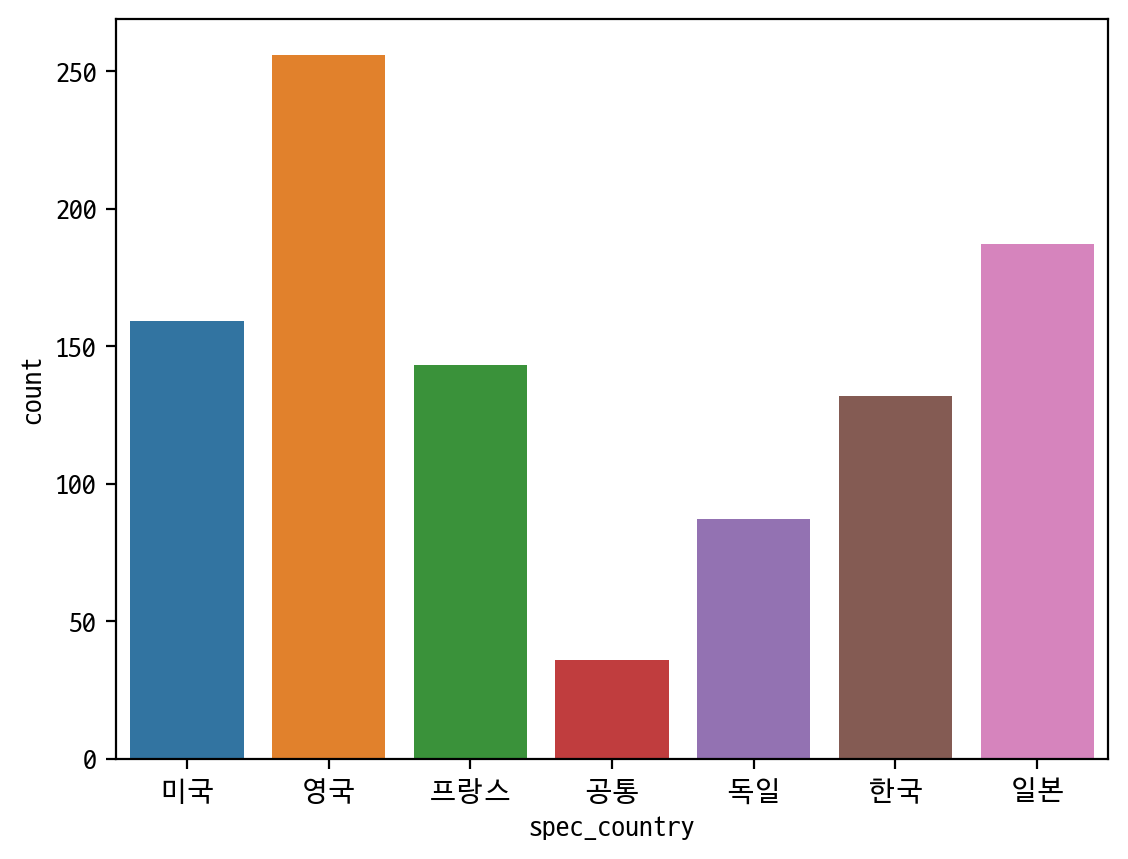

In [85]:
sns.countplot(x = 'spec_country', data  = df)

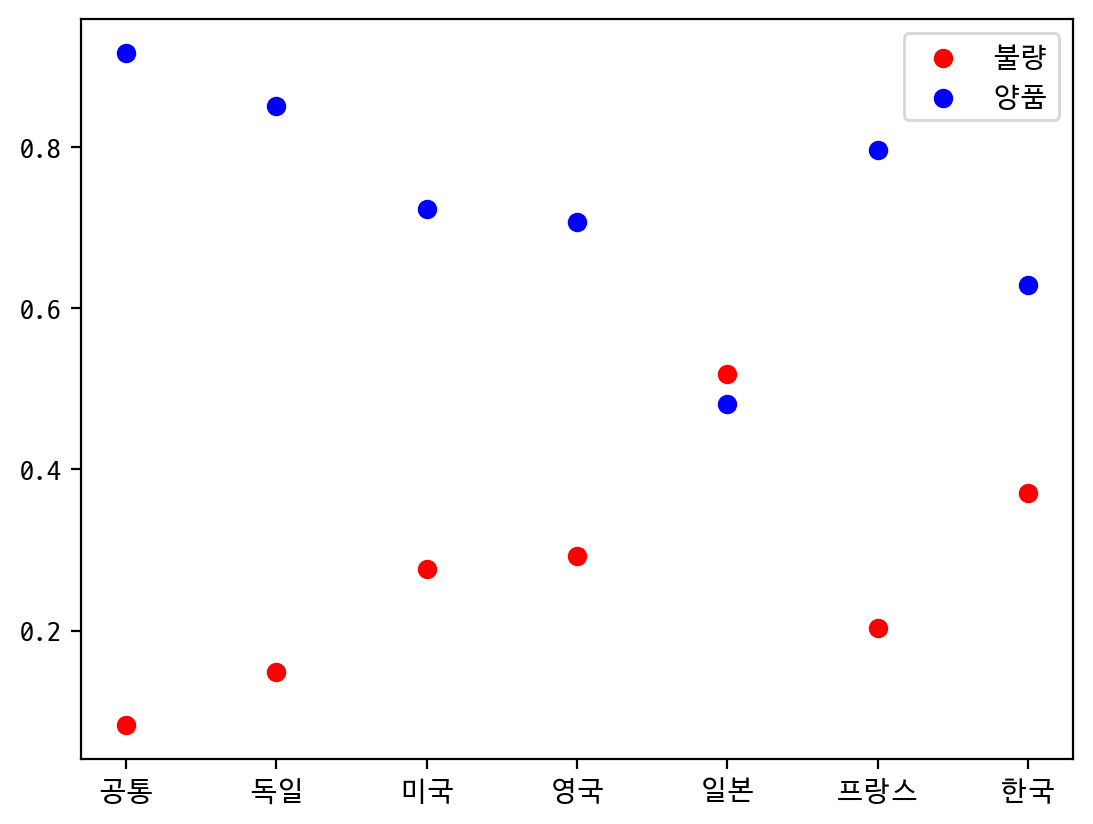

In [86]:
fun_print_crosstab(df,'spec_country')



## HSB

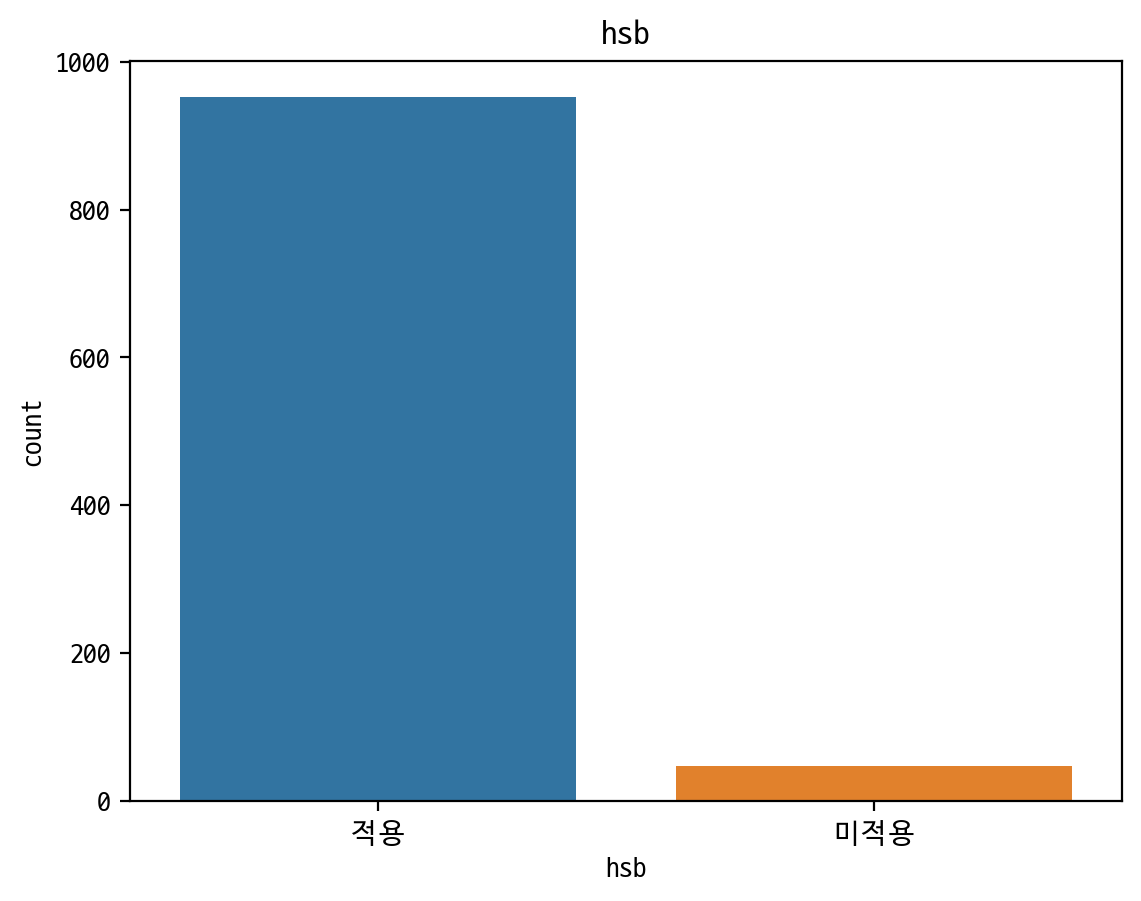

In [87]:
sns.countplot(x = 'hsb', data =df)
plt.title('hsb')
plt.show()

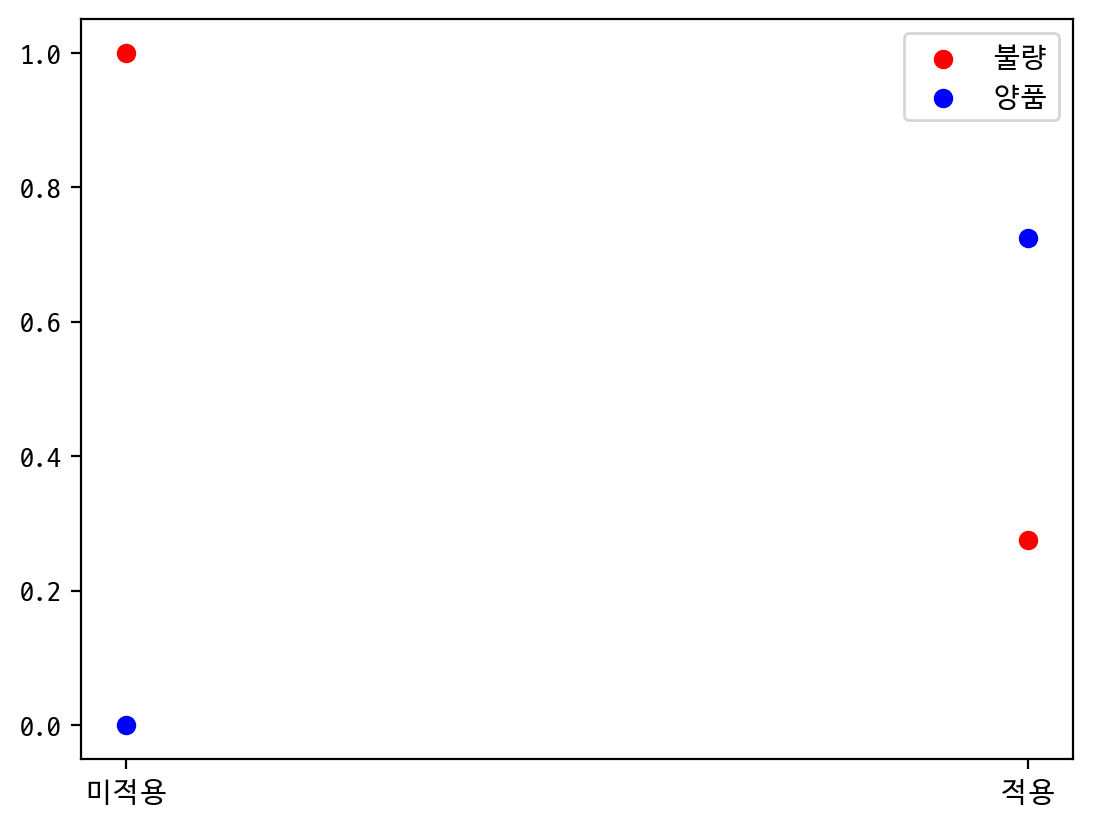

In [88]:
fun_print_crosstab(df,'hsb')


## rolling method

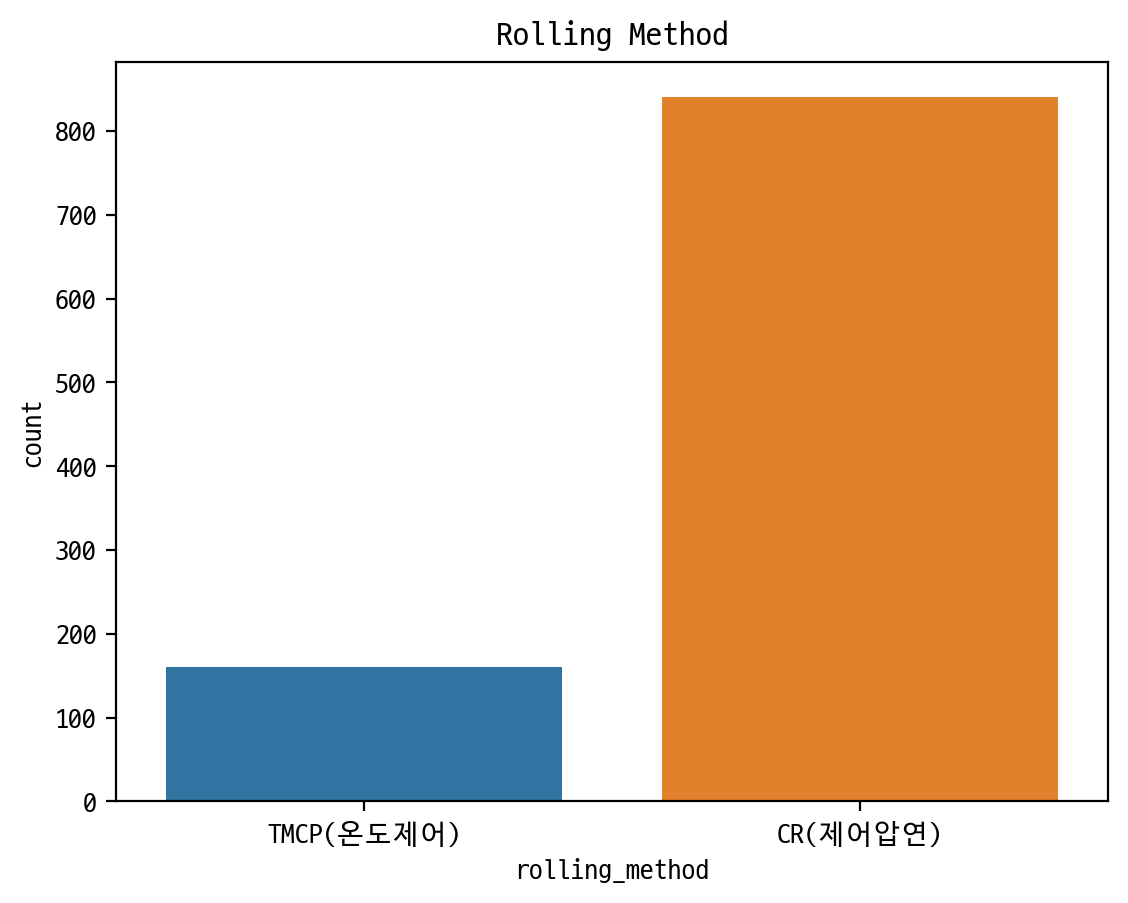

In [89]:
sns.countplot(x = 'rolling_method', data =df)
plt.title('Rolling Method')
plt.show()

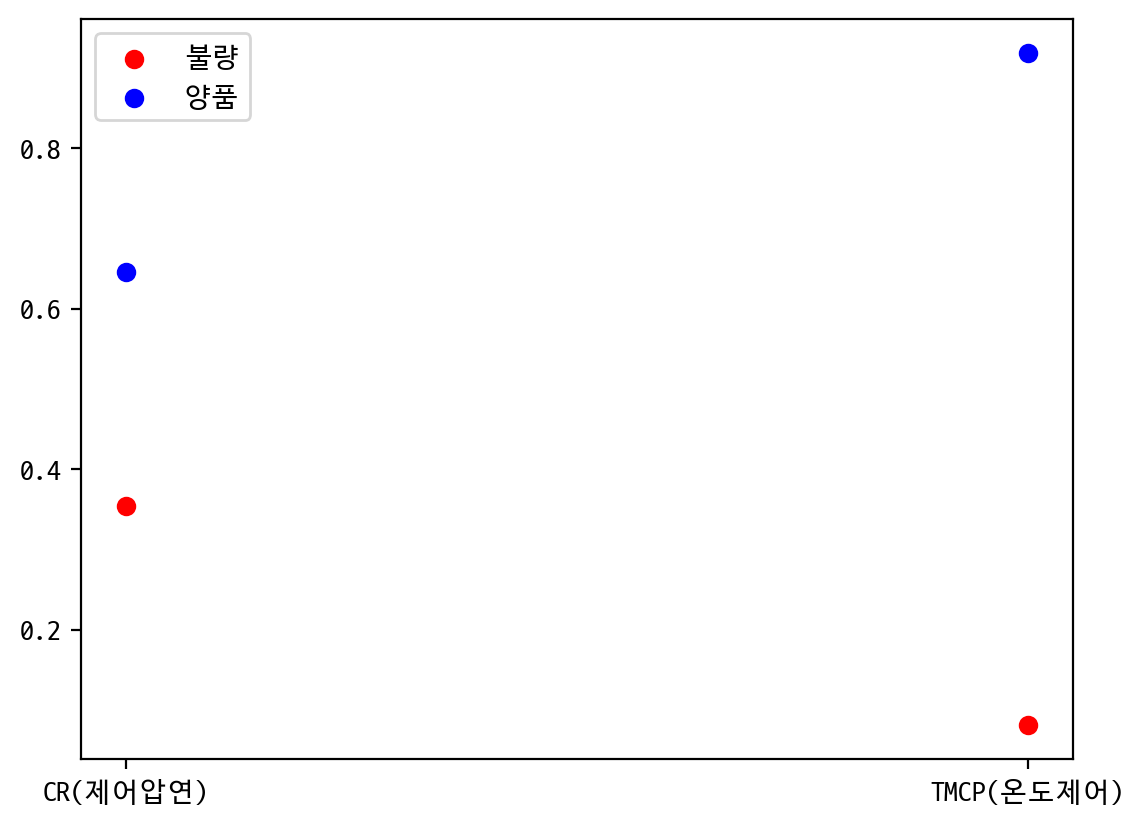

In [90]:
fun_print_crosstab(df,'rolling_method')

## work group

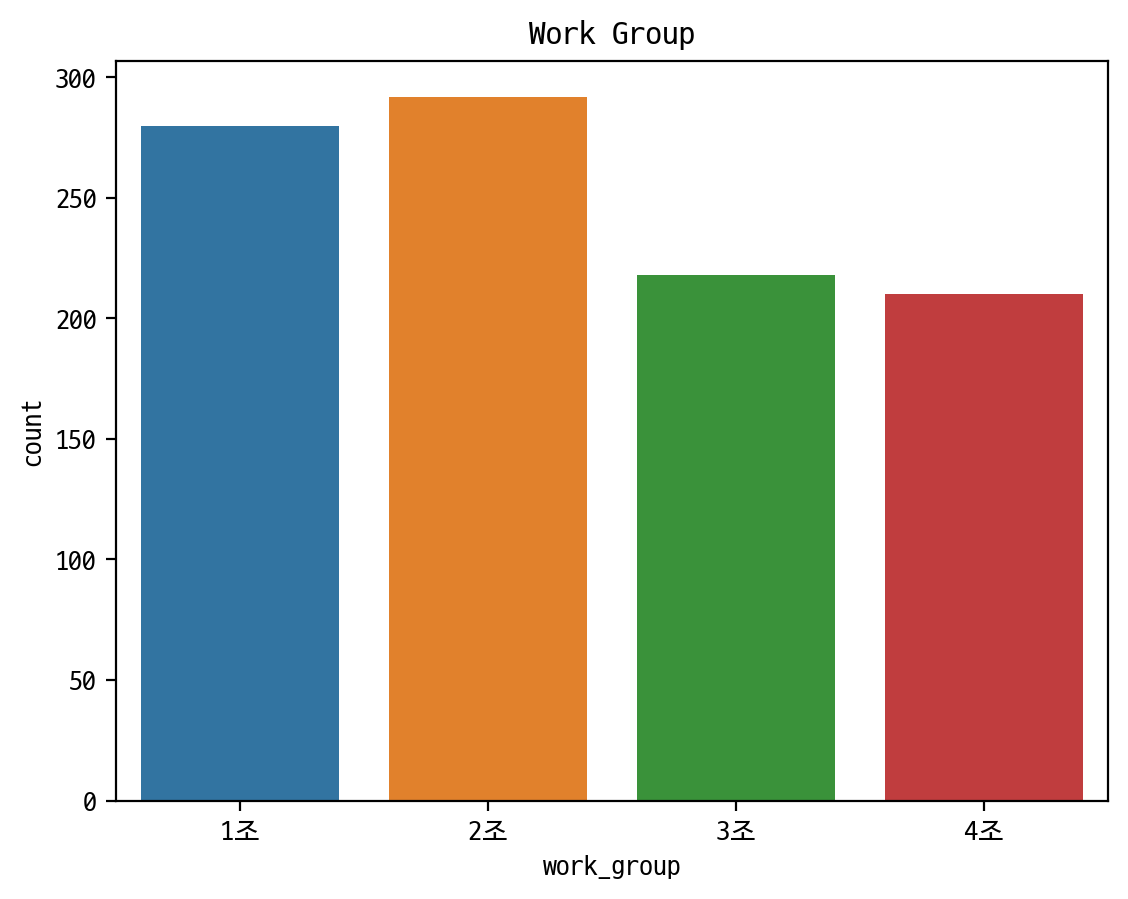

In [91]:
sns.countplot(x = 'work_group', data =df)
plt.title('Work Group')
plt.show()

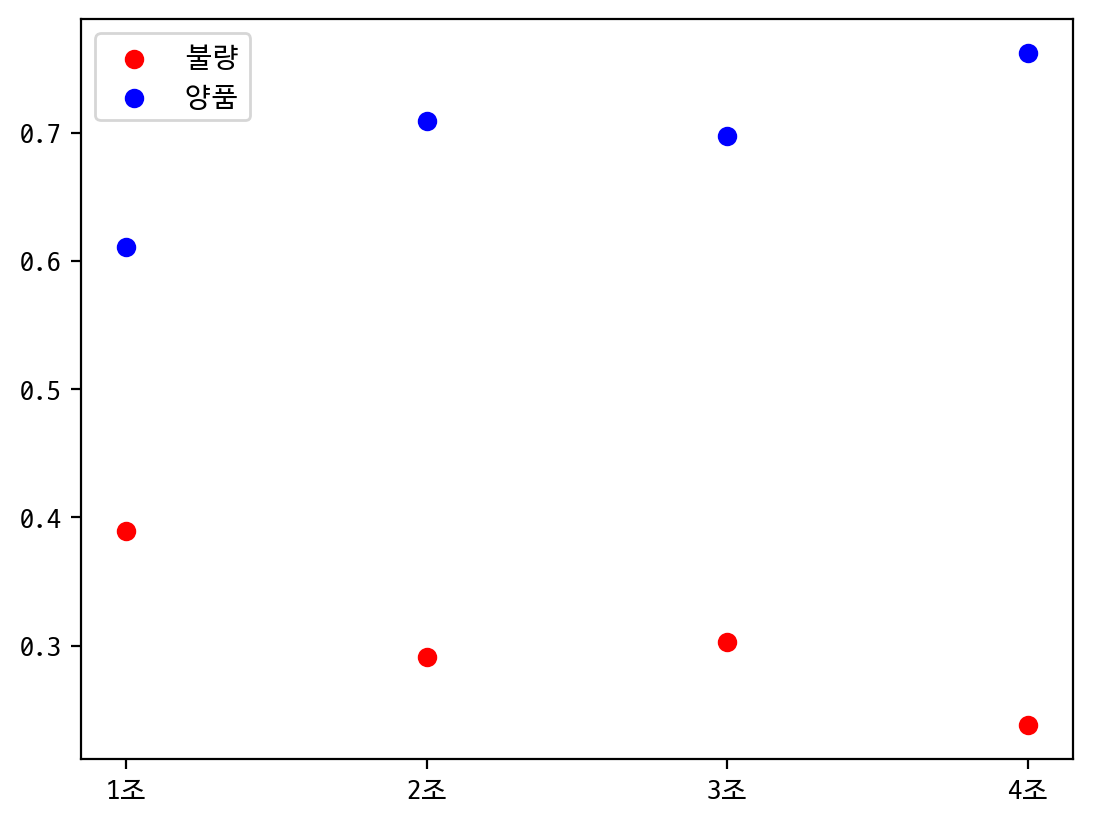

In [92]:
fun_print_crosstab(df,'work_group')

## Spec_long

In [93]:
df_temp = df[['spec_country','spec_long','scale']]
df_temp['scale'].replace(['불량','양품'], [1,0],inplace = True)
_temp = df_temp.groupby(['spec_country','spec_long'])['scale'].mean()

## Rolling_date

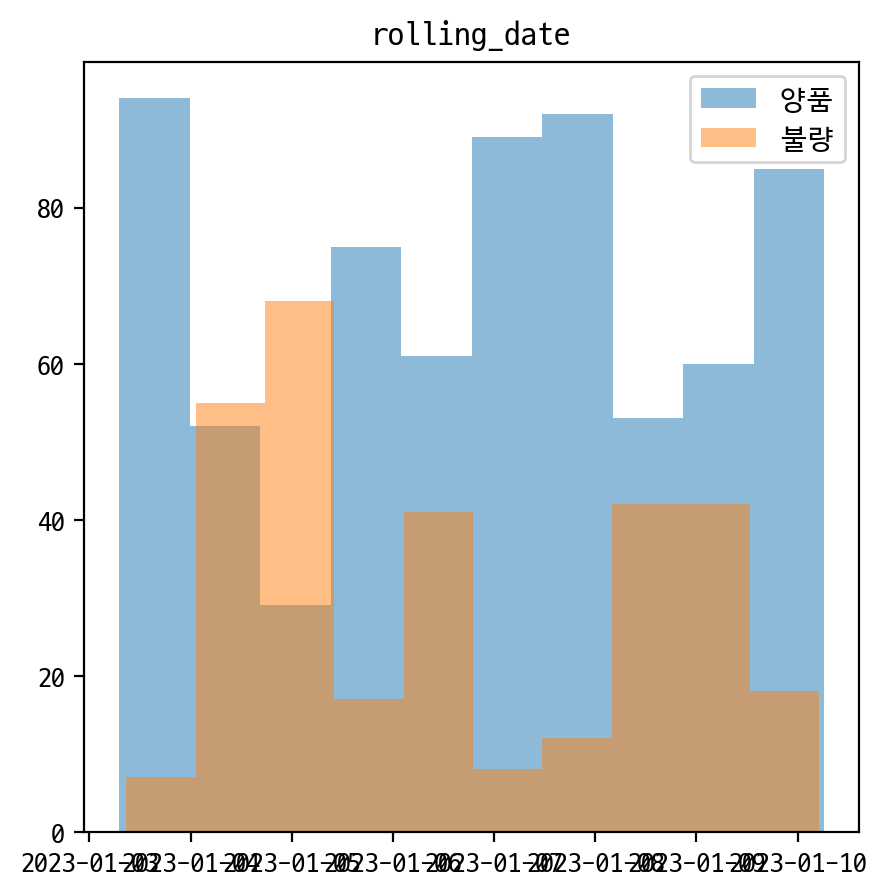

In [94]:
plt.figure(figsize = (5,5))
fun_plot_hist(df , 'rolling_date')

## 범주형, 수치형 변수 설정

In [95]:
num_col = df.select_dtypes(exclude='O').columns.to_list()
cat_col = df.select_dtypes(include='O').columns.to_list()
cat_col.remove('scale')

In [96]:
cat_col.remove('plate_no')
cat_col.remove('spec_long')
num_col.remove('rolling_date')
cat_col.remove('work_group')

In [97]:
print(num_col)
print(cat_col)

['pt_thick', 'pt_width', 'pt_length', 'fur_heat_temp', 'fur_heat_time', 'fur_soak_temp', 'fur_soak_time', 'fur_total_time', 'fur_ex_temp', 'rolling_temp', 'descaling_count']
['spec_country', 'steel_kind', 'hsb', 'fur_no', 'fur_input_row', 'rolling_method']


## pt_tick

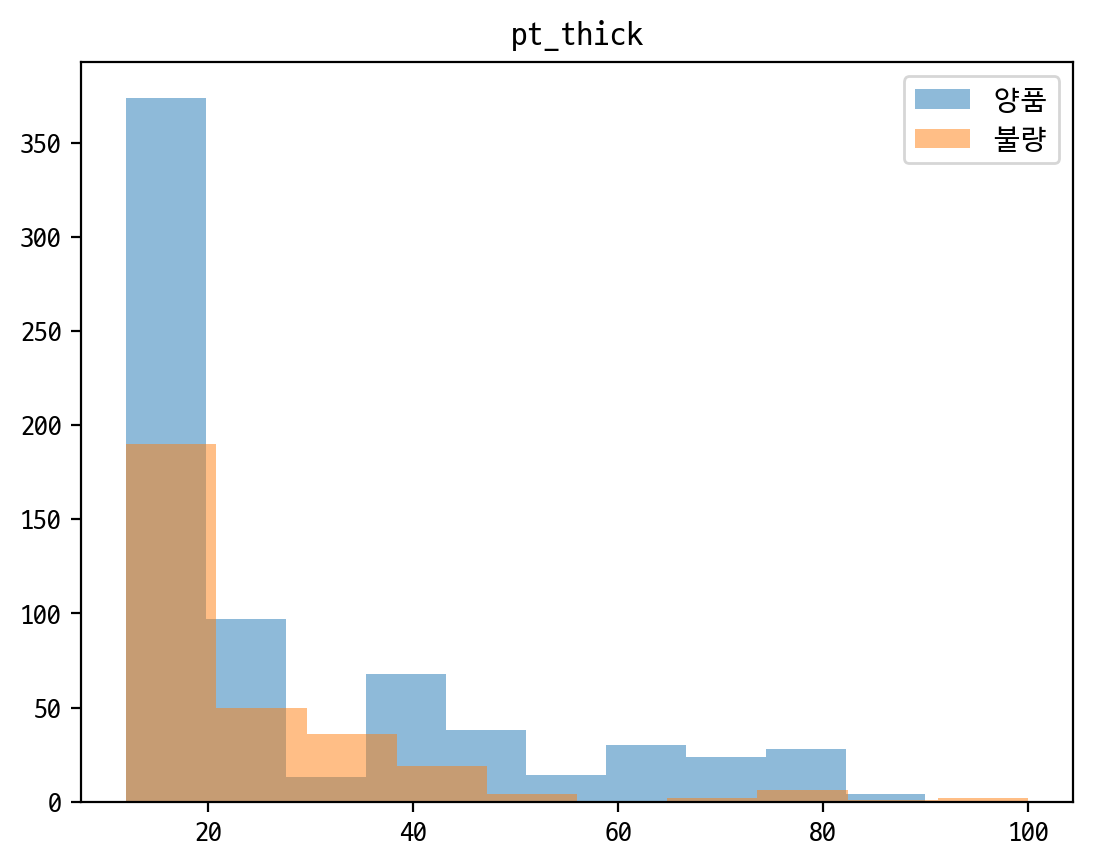

In [98]:
fun_plot_hist(df,'pt_thick')

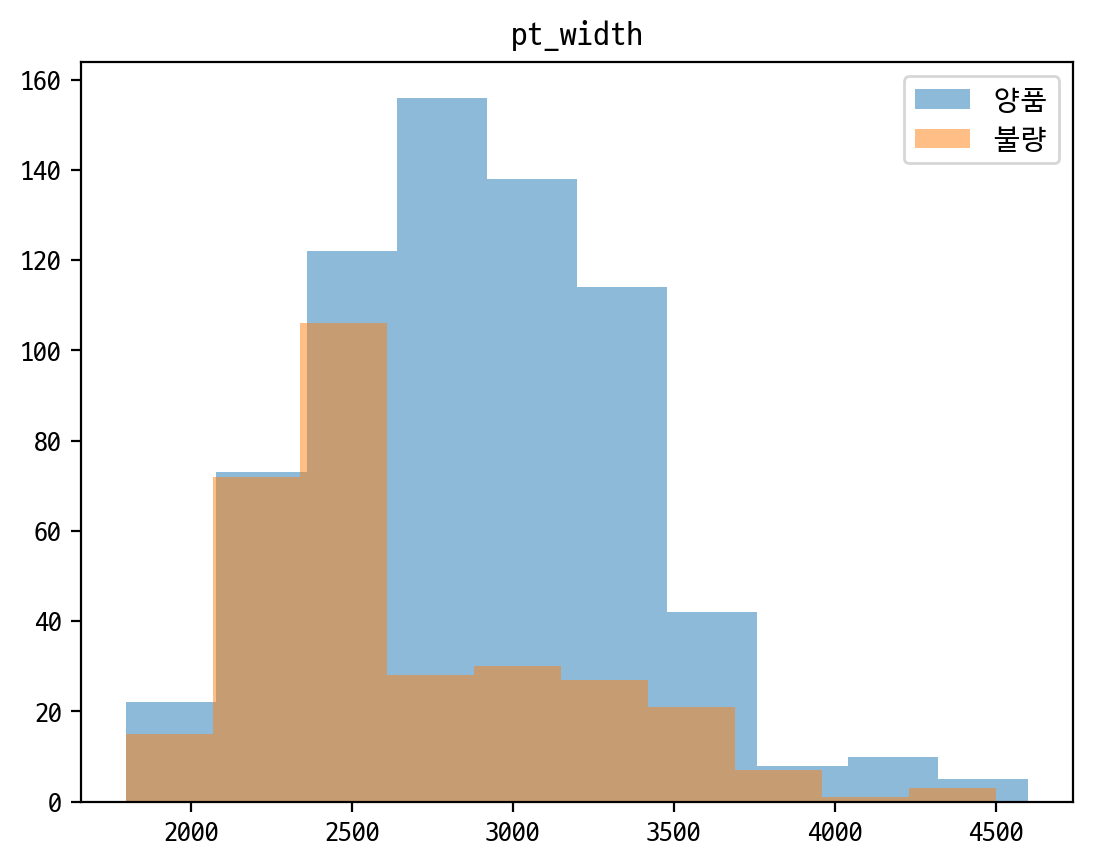

In [99]:
fun_plot_hist(df,'pt_width')

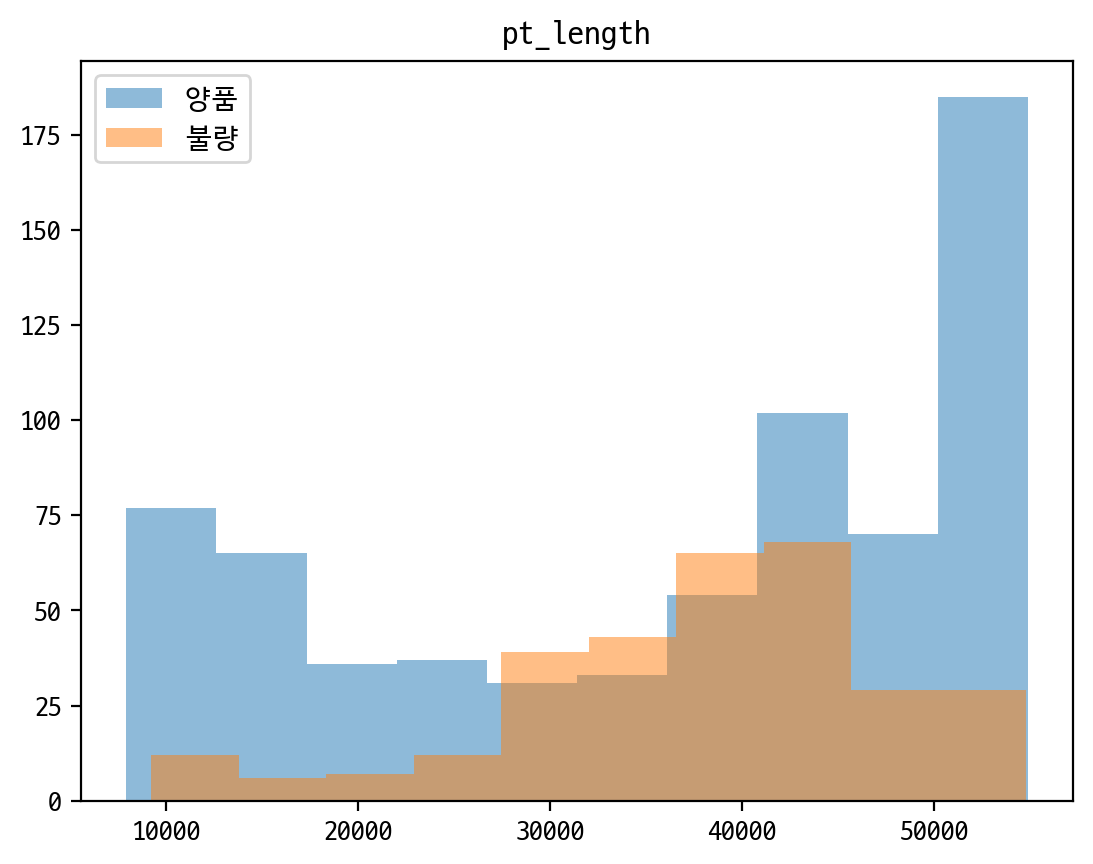

In [100]:
fun_plot_hist(df,'pt_length')

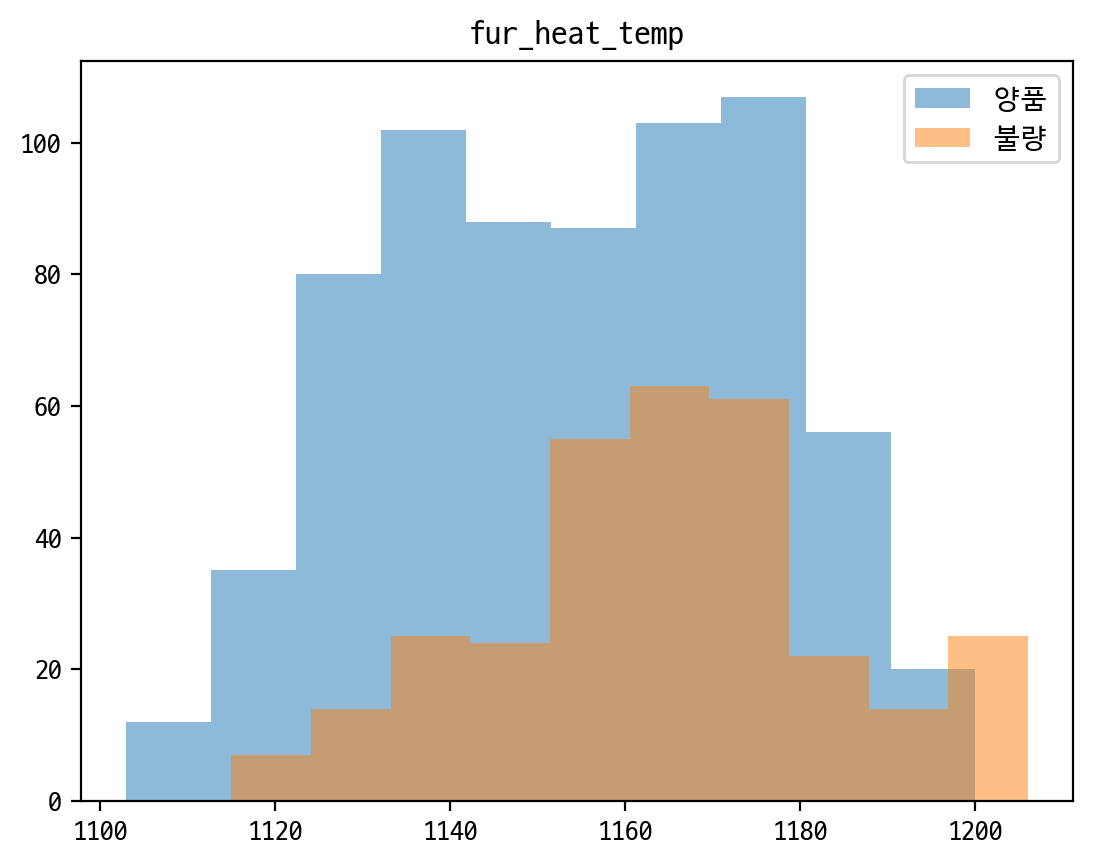

In [101]:
fun_plot_hist(df,'fur_heat_temp')

- 제품 생성 공정 과정에서의 무엇인가의 process의 이상한 점을 발견하였다.

- 이를 해결하는 것이 좋겠다.

## steel_kind

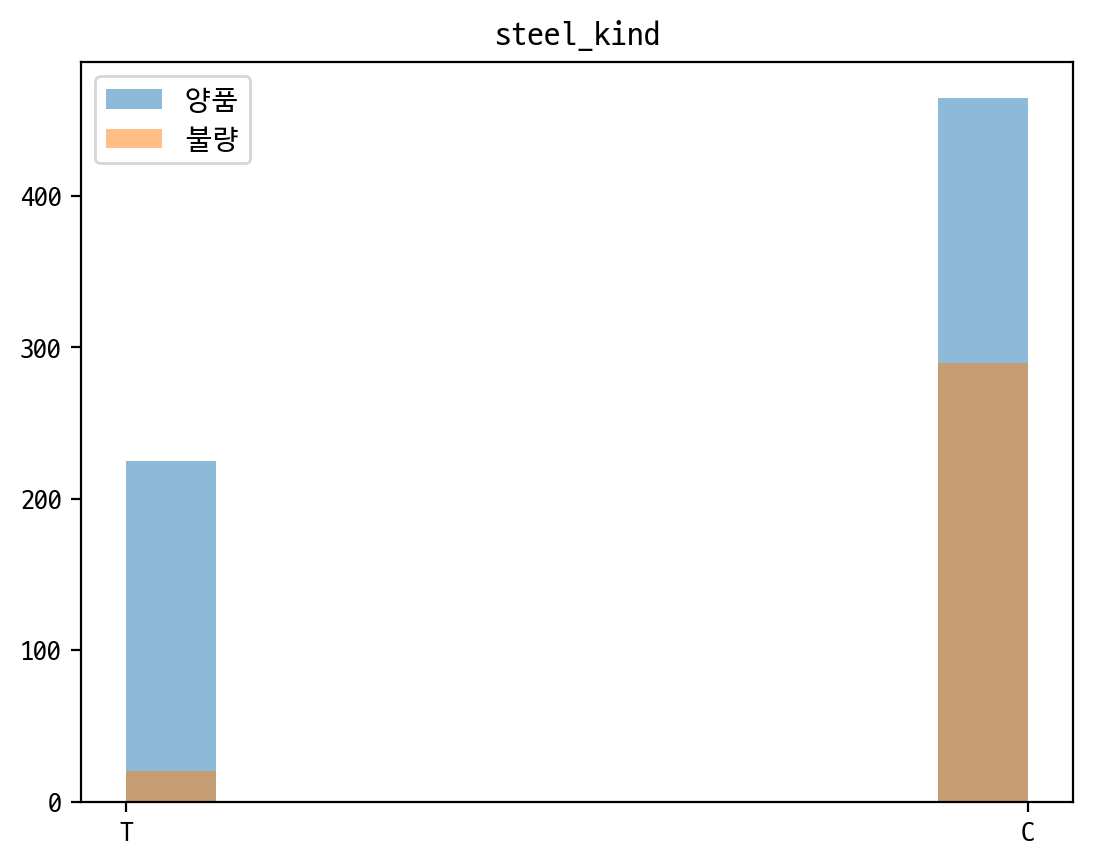

In [102]:
fun_plot_hist(df, 'steel_kind')

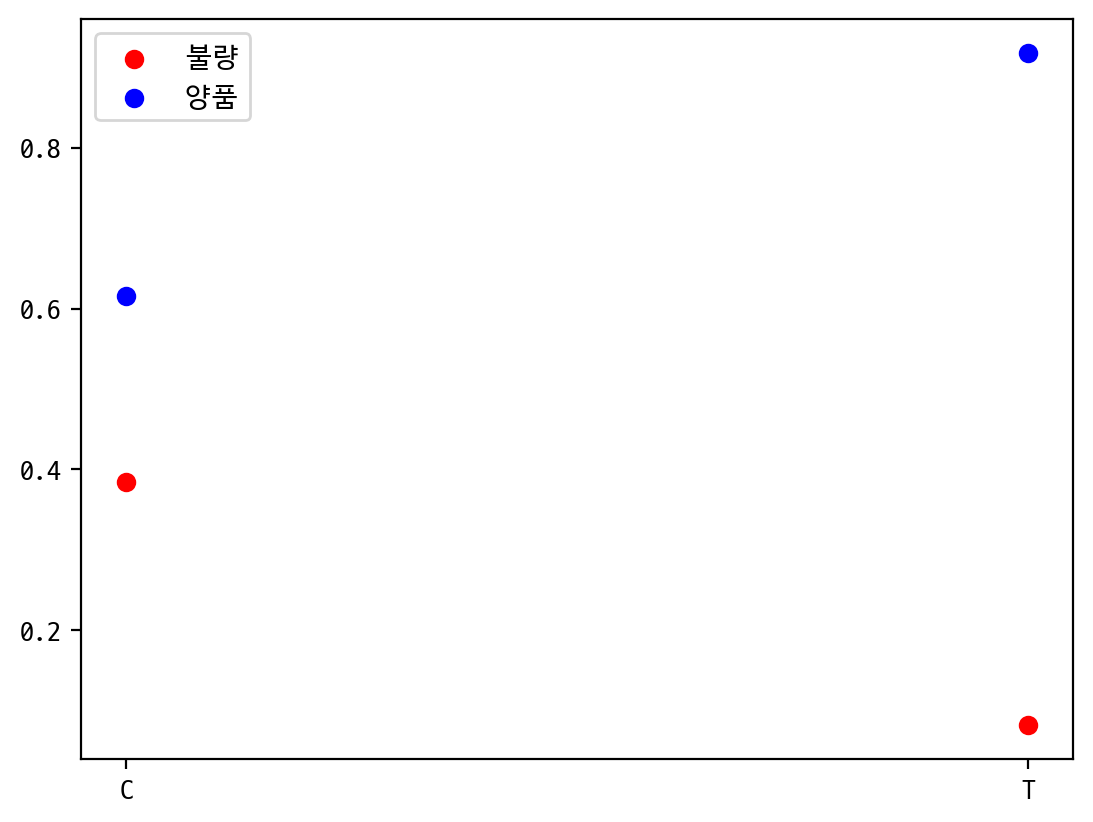

In [103]:
fun_print_crosstab(df,'steel_kind')

In [104]:
_temp = df[['rolling_method','steel_kind','scale']]
_temp['scale'].replace(['양품','불량'],[0,1], inplace = True)
pd.DataFrame(_temp.groupby(['rolling_method','steel_kind'])['scale'].sum())

scale
rolling_method steel_kind       
CR(제어압연)       C             290
               T               7
TMCP(온도제어)     T              13

## descaling

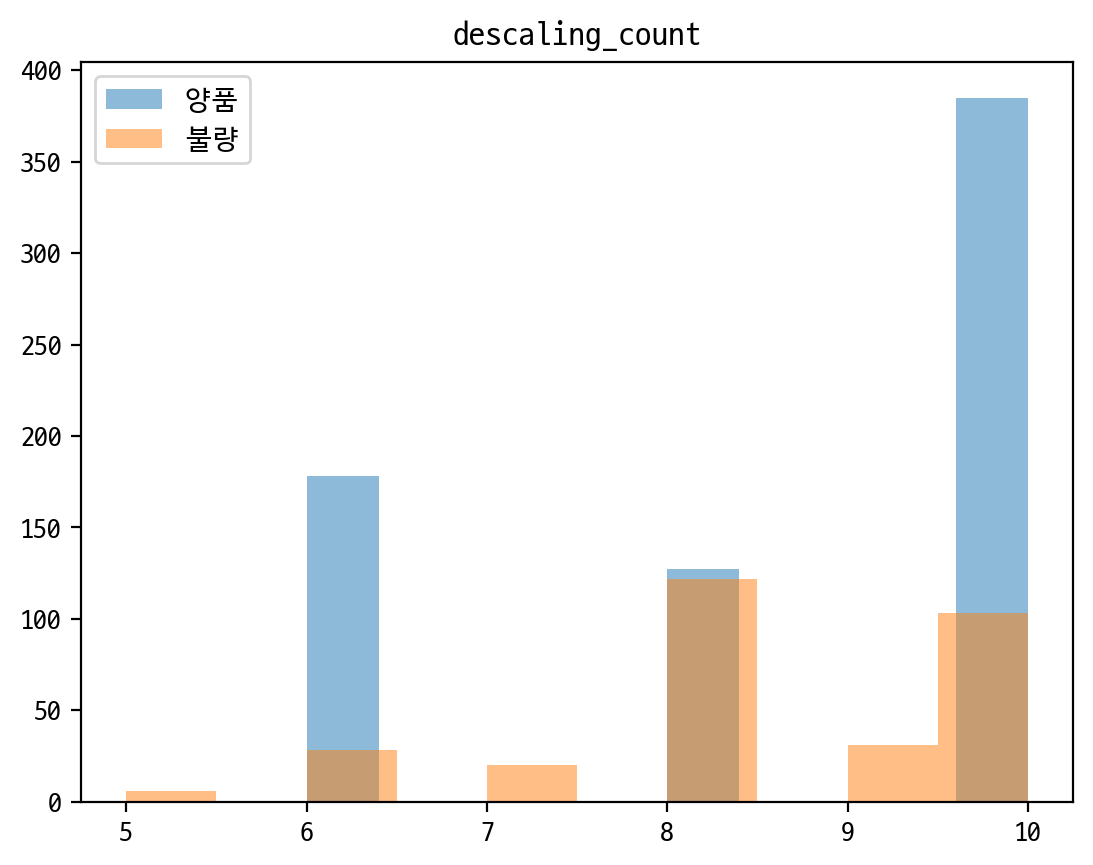

In [105]:
fun_plot_hist(df,'descaling_count')

## rolling temp

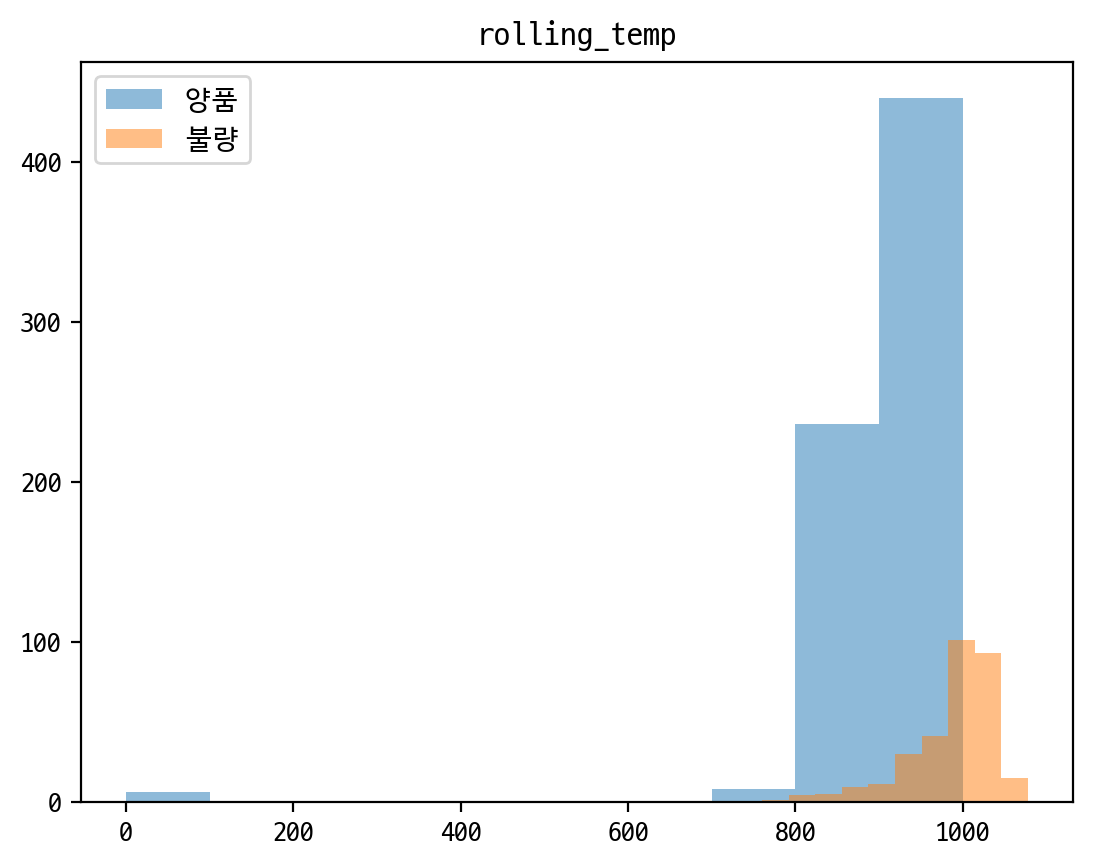

In [106]:
fun_plot_hist(df,'rolling_temp')

In [107]:
df[df['rolling_temp'] == 0]['rolling_temp'] = df['rolling_temp'].mean()

## 데이터 분리

In [108]:
## plate_no 와 spec_long은 별 관계가 없다고 생각되어 삭제하도록 한다.
df_drop = df.drop(['plate_no','spec_long','rolling_date','work_group'], axis = 1)


df_drop['scale'].replace(['양품','불량'], [0,1], inplace = True)
df_drop.steel_kind.replace(['C','T'], [1,0], inplace = True)
df_drop.hsb.replace(['적용','미적용'], [0,1], inplace = True)
df_drop.fur_input_row.replace(['1열','2열'], [0,1], inplace = True)
df_drop.rolling_method.replace(['CR(제어압연)', 'TMCP(온도제어)'], [1,0], inplace = True)


scaler = StandardScaler()
df_drop[num_col] = scaler.fit_transform(df_drop[num_col])
df_drop.info()

# 동일한 데이터 삭제
df_drop.drop('fur_ex_temp',axis =1 ,inplace = True )
num_col.remove('fur_ex_temp')

df_drop_x = df_drop.drop(['scale'], axis = 1)
df_drop_y = df_drop['scale'].astype('int')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   scale            1000 non-null   int64  
 1   spec_country     1000 non-null   object 
 2   steel_kind       1000 non-null   int64  
 3   pt_thick         1000 non-null   float64
 4   pt_width         1000 non-null   float64
 5   pt_length        1000 non-null   float64
 6   hsb              1000 non-null   int64  
 7   fur_no           1000 non-null   object 
 8   fur_input_row    1000 non-null   int64  
 9   fur_heat_temp    1000 non-null   float64
 10  fur_heat_time    1000 non-null   float64
 11  fur_soak_temp    1000 non-null   float64
 12  fur_soak_time    1000 non-null   float64
 13  fur_total_time   1000 non-null   float64
 14  fur_ex_temp      1000 non-null   float64
 15  rolling_method   1000 non-null   int64  
 16  rolling_temp     1000 non-null   float64
 17  descaling_count

In [109]:
x_train , x_test, y_train, y_test = train_test_split(df_drop_x, df_drop_y, test_size= .3, stratify= df_drop_y, random_state= 42)

# 로지스틱 회귀분석

In [110]:
# 상수항 추가
x_train = sm.add_constant(x_train)

# 데이터 타입 변경
x_train['spec_country'] = x_train['spec_country'].astype('category')
x_train['fur_no'] = x_train['fur_no'].astype('category')
# 회귀분석 모델 생성
form1 = '+'.join(['C({})'.format(i) for i in ['spec_country', 'fur_no']])
form2 = '+'.join(num_col)
formula = 'scale ~ ' + form1 + '+' + form2
train = x_train.join(y_train)
log_model = Logit.from_formula(formula, data=train)
log_result = log_model.fit()

print(log_result.summary())

Optimization terminated successfully.
         Current function value: 0.404827
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  scale   No. Observations:                  700
Model:                          Logit   Df Residuals:                      681
Method:                           MLE   Df Model:                           18
Date:                Wed, 09 Aug 2023   Pseudo R-squ.:                  0.3461
Time:                        04:52:03   Log-Likelihood:                -283.38
converged:                       True   LL-Null:                       -433.37
Covariance Type:            nonrobust   LLR p-value:                 4.853e-53
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -1.7537      0.824     -2.128      0.033      -3.369      

In [111]:
y_pred_train = log_result.predict(x_train)
y_pred_train_class = (y_pred_train > 0.5).astype(int)
print(classification_report(y_train, y_pred_train_class, digits = 3))
y_pred_test = log_result.predict(x_test)
y_pred_test_class = (y_pred_test > 0.5).astype(int)
print(classification_report(y_test, y_pred_test_class, digits = 3))

              precision    recall  f1-score   support

           0      0.842     0.894     0.867       483
           1      0.727     0.627     0.673       217

    accuracy                          0.811       700
   macro avg      0.785     0.761     0.770       700
weighted avg      0.807     0.811     0.807       700

              precision    recall  f1-score   support

           0      0.870     0.903     0.886       207
           1      0.765     0.699     0.730        93

    accuracy                          0.840       300
   macro avg      0.817     0.801     0.808       300
weighted avg      0.837     0.840     0.838       300



In [112]:
def vifs(df):
    vif = pd.DataFrame()
    vif['Variable'] = df.columns
    vif['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif

print(vifs(x_train[num_col]))
## 다중공선성 만족

          Variable       VIF
0         pt_thick  6.580850
1         pt_width  1.328226
2        pt_length  5.056070
3    fur_heat_temp  3.019115
4    fur_heat_time  4.016103
5    fur_soak_temp  5.848213
6    fur_soak_time  3.800883
7   fur_total_time  6.380319
8     rolling_temp  1.486767
9  descaling_count  4.352183


# 다중공선성 체크

<Axes: >

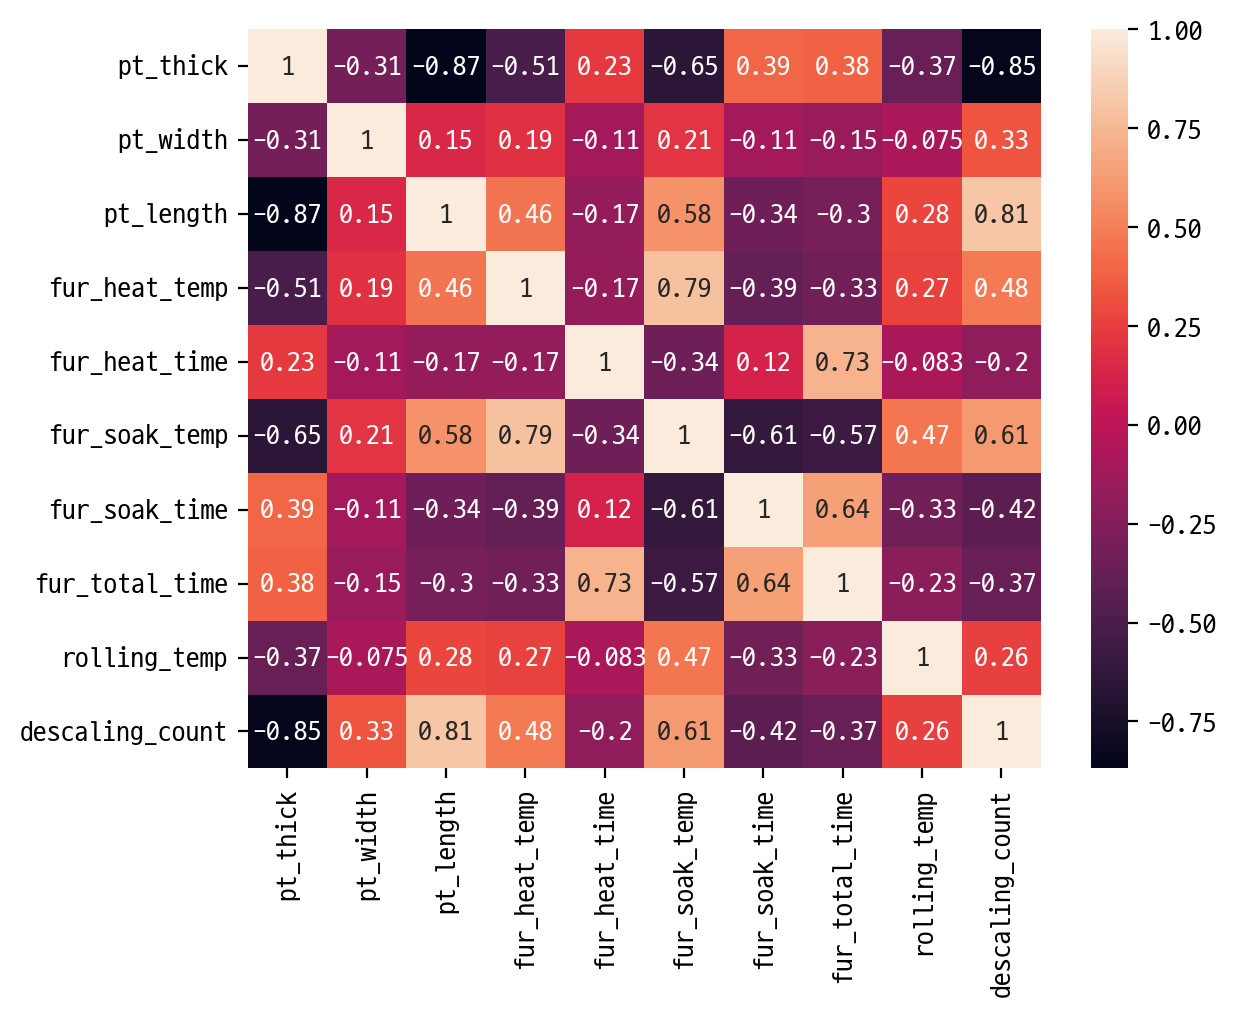

In [113]:
sns.heatmap(x_train[num_col].corr(), annot = True)

In [114]:
## 2개 이상의 변수들과 상관관계가 높은 변수들은 pt_thick , fur_soak_temp 가 있으나 로지스틱 회귀 분석에서 p-value가 낮게 나와서 유의미하므로 지우지 않도록 하겠다.

In [115]:
# 상수항 추가
x_train = sm.add_constant(x_train)

# 데이터 타입 변경
x_train['spec_country'] = x_train['spec_country'].astype('category')
x_train['fur_no'] = x_train['fur_no'].astype('category')
# 회귀분석 모델 생성
form1 = '+'.join(['C({})'.format(i) for i in ['spec_country', 'fur_no']])
num_col.remove('pt_thick')
num_col.remove('fur_total_time')
form2 = '+'.join(num_col)
formula = 'scale ~ ' + form1 + '+' + form2
train = x_train.join(y_train)
log_model = Logit.from_formula(formula, data=train)
log_result = log_model.fit()

print(log_result.summary())

Optimization terminated successfully.
         Current function value: 0.405003
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  scale   No. Observations:                  700
Model:                          Logit   Df Residuals:                      683
Method:                           MLE   Df Model:                           16
Date:                Wed, 09 Aug 2023   Pseudo R-squ.:                  0.3458
Time:                        04:52:03   Log-Likelihood:                -283.50
converged:                       True   LL-Null:                       -433.37
Covariance Type:            nonrobust   LLR p-value:                 2.891e-54
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -1.7521      0.825     -2.125      0.034      -3.368      

In [116]:
x_train.drop('const', axis = 1, inplace = True)


In [117]:
y_pred_train = log_result.predict(x_train)
y_pred_train_class = (y_pred_train > 0.5).astype(int)
print(classification_report(y_train, y_pred_train_class, digits = 3))
y_pred_test = log_result.predict(x_test)
y_pred_test_class = (y_pred_test > 0.5).astype(int)
print(classification_report(y_test, y_pred_test_class, digits = 3))

              precision    recall  f1-score   support

           0      0.846     0.896     0.870       483
           1      0.734     0.636     0.681       217

    accuracy                          0.816       700
   macro avg      0.790     0.766     0.776       700
weighted avg      0.811     0.816     0.812       700

              precision    recall  f1-score   support

           0      0.878     0.903     0.890       207
           1      0.770     0.720     0.744        93

    accuracy                          0.847       300
   macro avg      0.824     0.812     0.817       300
weighted avg      0.845     0.847     0.845       300



<Axes: >

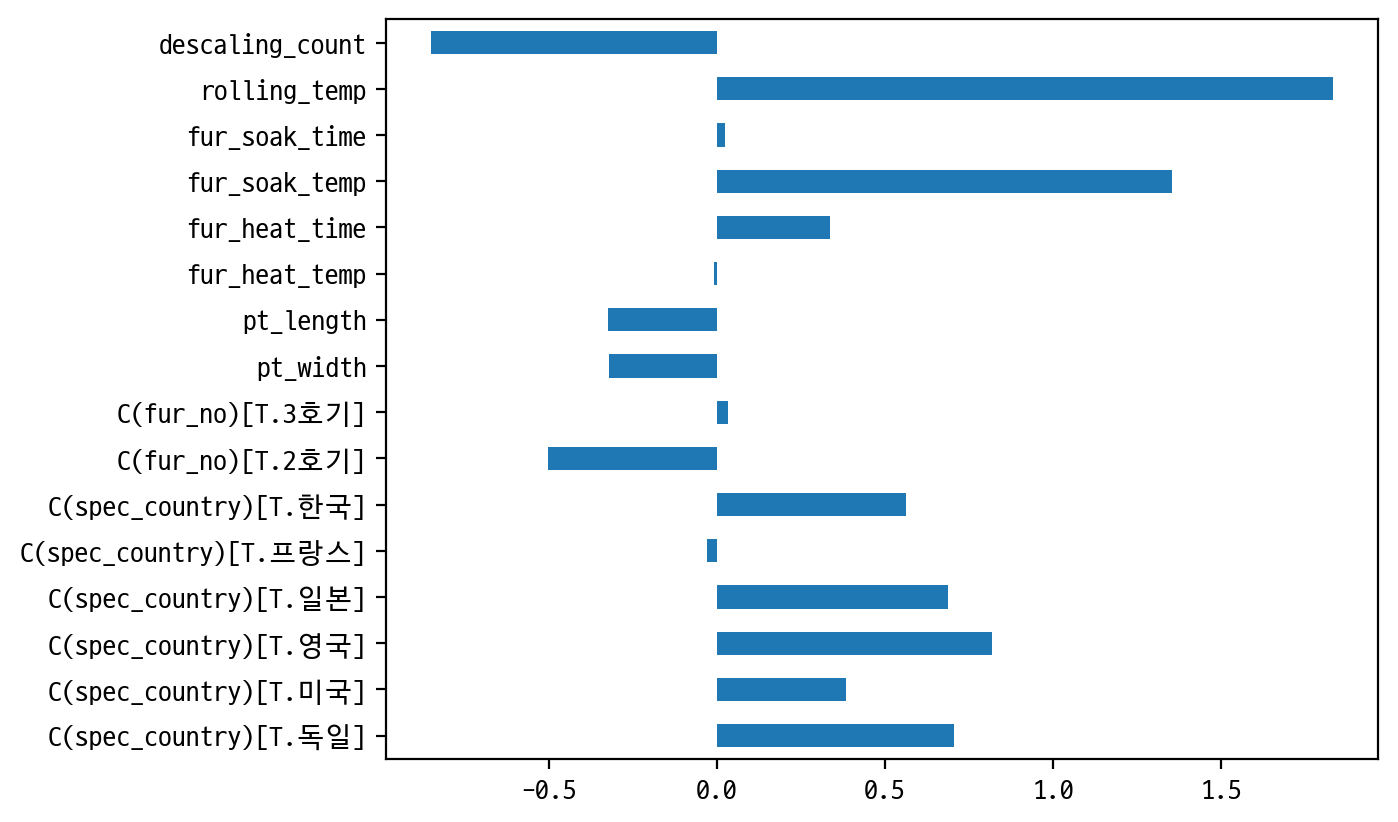

In [118]:
df_scaled_coef = pd.DataFrame({'Coef' : log_result.params.values[1:]}, index = log_model.exog_names[1:])
df_scaled_coef.plot.barh(y='Coef', legend = False)

# 의사결정 트리

In [119]:
x_train = pd.get_dummies(x_train)
x_test = pd.get_dummies(x_test)

In [120]:
tree_uncust = DecisionTreeClassifier(random_state = 42)
tree_uncust.fit(x_train, y_train)

scores = pd.DataFrame({'uncustomized_tree' : [tree_uncust.score(x_train, y_train), tree_uncust.score(x_test,y_test)]}, index = ['train','test'])

scores

,uncustomized_tree
train,1.000000
test,0.976667


In [121]:
import re

y_pred = tree_uncust.predict(x_test)
cls_report_uncust = classification_report(y_test, y_pred , digits = 3)

def cls_reports(cls_report , model):    
    lines = cls_report.strip().split('\n')
    lines = [line.strip() for line in lines if line.strip() != '']

    # Initialize dictionaries to store values for each metric
    metrics = {'precision' + '_' + model: [], 'recall' + '_' + model: [], 'f1-score' + '_' + model: [], 'support' + '_' + model: []}

    for line in lines[1:]:
        parts = line.split()
        if parts[0] == 'accuracy':
            metrics['precision' + '_' + model].append('-')
            metrics['recall' + '_' + model].append('-')
            metrics['f1-score' + '_' + model].append(float(parts[1]))
            metrics['support' + '_' + model].append(int(parts[2]))
        else:
            if (parts[0] == 'macro' )| (parts[0] == 'weighted'):
                metrics['precision' + '_' + model].append(float(parts[2]))
                metrics['recall' + '_' + model].append(float(parts[3]))
                metrics['f1-score' + '_' + model].append(float(parts[4]))
                metrics['support' + '_' + model].append(int(parts[5]))
            else:
                metrics['precision' + '_' + model].append(float(parts[1]))
                metrics['recall' + '_' + model].append(float(parts[2]))
                metrics['f1-score' + '_' + model].append(float(parts[3]))
                metrics['support' + '_' + model].append(int(parts[4]))

    # Creating the DataFrame
    df = pd.DataFrame(metrics, index=['0', '1', 'accuracy', 'macro avg', 'weighted avg'])

    return df

cls_reports(cls_report_uncust, 'tree')





,precision_tree,recall_tree,f1-score_tree,support_tree
0,0.99,0.976,0.983,207
1,0.948,0.978,0.963,93
accuracy,-,-,0.977,300
macro avg,0.969,0.977,0.973,300
weighted avg,0.977,0.977,0.977,300


## 가지치기

,Depth,TrainAccuracy,TestAccuracy
0,3,0.954286,0.973333
1,4,0.960000,0.980000
2,5,0.960000,0.980000
3,6,0.988571,0.993333
4,7,0.990000,0.980000
5,8,0.992857,0.983333
6,9,0.997143,0.983333
7,10,0.998571,0.983333
8,11,1.000000,0.976667


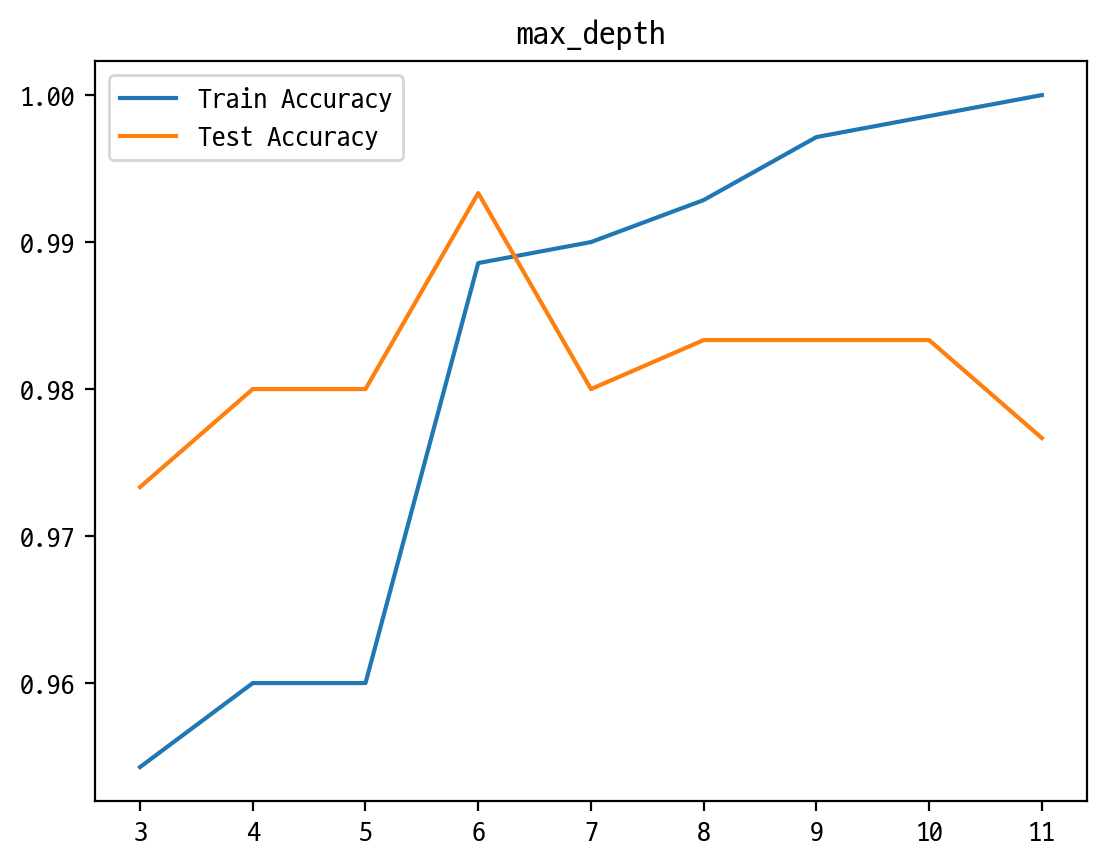

In [122]:
train_accuracy , test_accuracy = [],[]

para_depth = [depth for depth in range(3,12)]

for v_max_depth in para_depth:
    tree = DecisionTreeClassifier(max_depth = v_max_depth , random_state= 42)
    tree.fit(x_train, y_train)
    train_accuracy.append(tree.score(x_train, y_train))
    test_accuracy.append(tree.score(x_test, y_test))

df_accuracy_depth = pd.DataFrame()
df_accuracy_depth['Depth'] = para_depth
df_accuracy_depth['TrainAccuracy'] = train_accuracy
df_accuracy_depth['TestAccuracy'] = test_accuracy

display(df_accuracy_depth)

plt.plot(para_depth, train_accuracy, linestyle = '-', label = 'Train Accuracy')
plt.plot(para_depth, test_accuracy, linestyle = '-', label = 'Test Accuracy')
plt.title("max_depth")
plt.legend()


- 10 또는 9를 선택하도록 하겠다.

,MinSampleSplit,TrainAccuracy,TestAccuracy
0,2,0.992857,0.983333
1,4,0.992857,0.983333
2,6,0.990000,0.980000
3,8,0.990000,0.980000
4,10,0.990000,0.980000
5,12,0.990000,0.980000
6,14,0.990000,0.980000
7,16,0.990000,0.980000
8,18,0.990000,0.980000
9,20,0.990000,0.980000


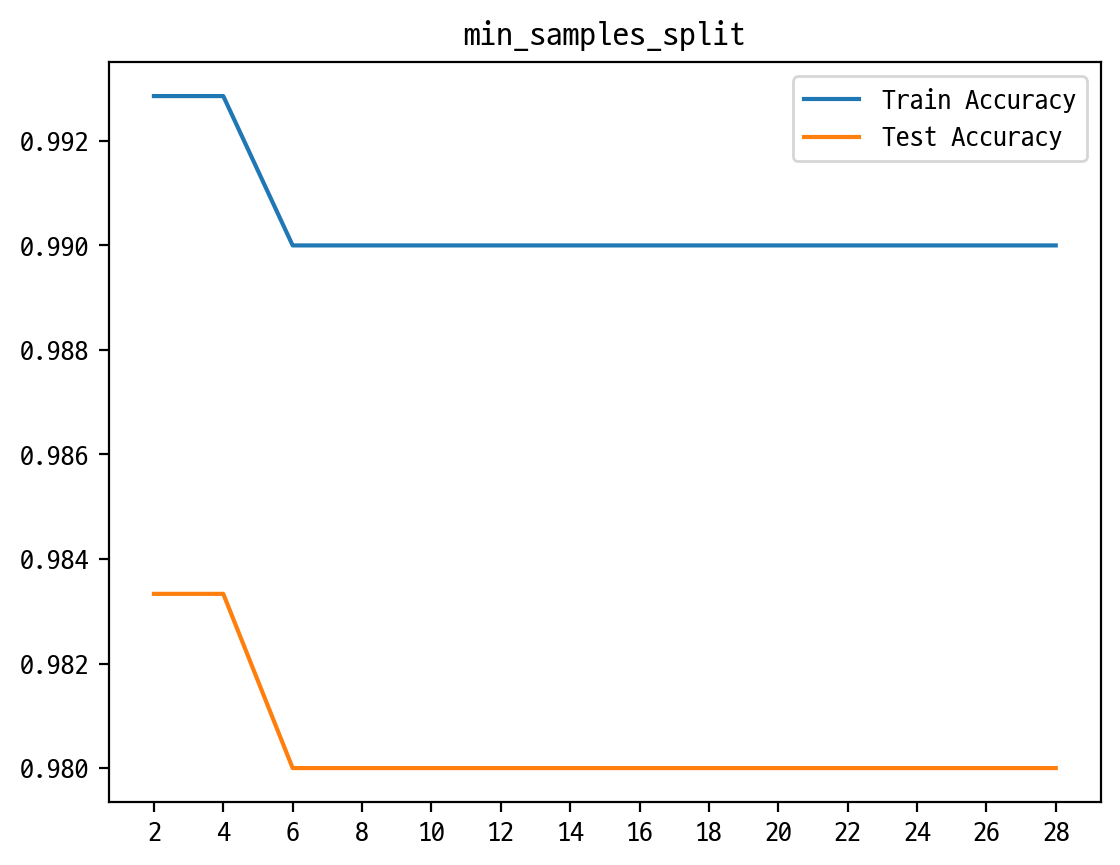

In [123]:
train_accuracy , test_accuracy = [],[]

para_split = [n_split * 2 for n_split in range(1,15)]

for v_min_samples_split in para_split:
    tree = DecisionTreeClassifier(min_samples_split = v_min_samples_split , max_depth = 8, random_state= 42)
    tree.fit(x_train, y_train)
    train_accuracy.append(tree.score(x_train, y_train))
    test_accuracy.append(tree.score(x_test, y_test))

df_accuracy_split = pd.DataFrame()
df_accuracy_split['MinSampleSplit'] = para_split
df_accuracy_split['TrainAccuracy'] = train_accuracy
df_accuracy_split['TestAccuracy'] = test_accuracy

display(df_accuracy_split)

plt.plot(para_split, train_accuracy, linestyle = '-', label = 'Train Accuracy')
plt.plot(para_split, test_accuracy, linestyle = '-', label = 'Test Accuracy')
plt.xticks(para_split)
plt.title('min_samples_split')
plt.legend()


- 아예 설정해주지 않도록 하겠다. 

,MinSampleSplit,TrainAccuracy,TestAccuracy
0,2,0.992857,0.983333
1,4,0.990000,0.980000
2,6,0.982857,0.986667
3,8,0.982857,0.986667
4,10,0.987143,0.970000
5,12,0.987143,0.970000
6,14,0.987143,0.970000
7,16,0.982857,0.986667
8,18,0.982857,0.986667
9,20,0.982857,0.986667


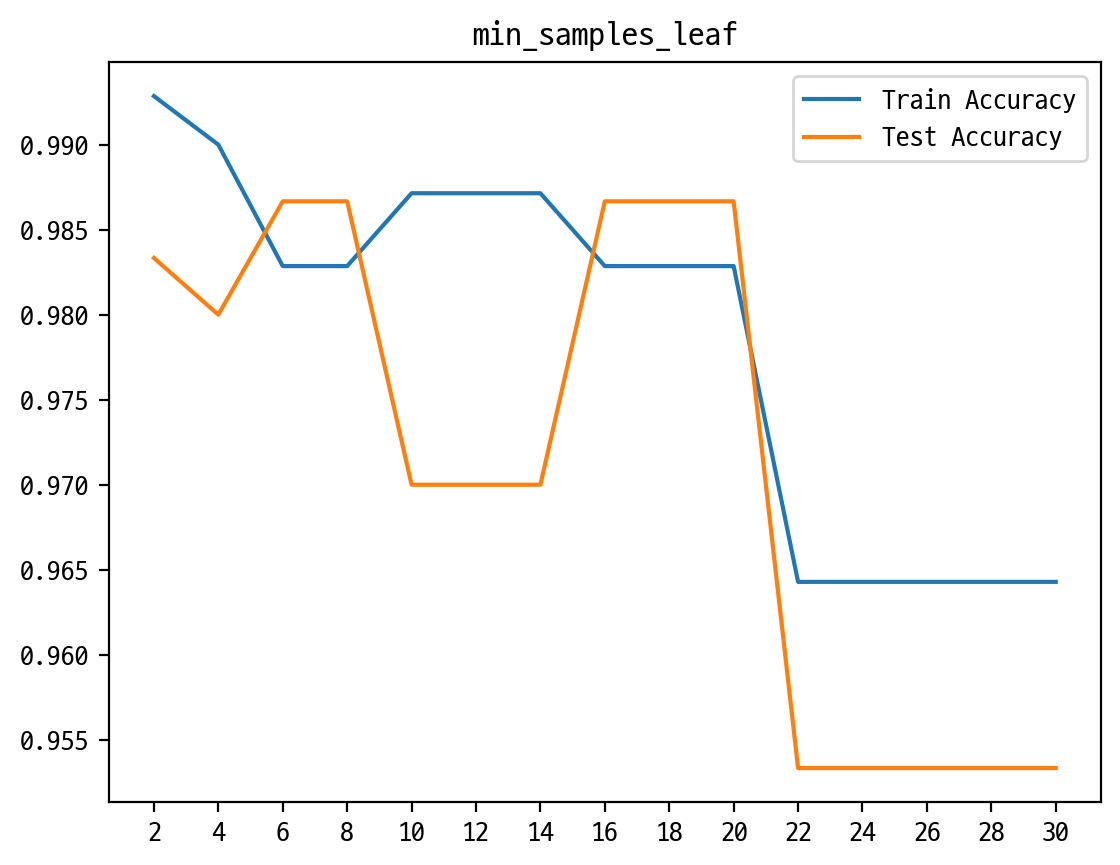

In [124]:
train_accuracy , test_accuracy = [],[]

para_leaf = [n_leaf * 2 for n_leaf in range(1,16)]

for v_min_samples_leaf in para_leaf:
    tree = DecisionTreeClassifier(min_samples_leaf = v_min_samples_leaf ,max_depth = 8 ,random_state= 42)
    tree.fit(x_train, y_train)
    train_accuracy.append(tree.score(x_train, y_train))
    test_accuracy.append(tree.score(x_test, y_test))

df_accuarcy_leaf = pd.DataFrame()
df_accuarcy_leaf['MinSampleSplit'] = para_leaf
df_accuarcy_leaf['TrainAccuracy'] = train_accuracy
df_accuarcy_leaf['TestAccuracy'] = test_accuracy

display(df_accuarcy_leaf)

plt.plot(para_leaf, train_accuracy, linestyle = '-', label = 'Train Accuracy')
plt.plot(para_leaf, test_accuracy, linestyle = '-', label = 'Test Accuracy')
plt.xticks(para_leaf)
plt.title('min_samples_leaf')
plt.legend()

선택 하지 않도록 하겠다.

## 최종모델 선정

In [125]:
params = tree_uncust.get_params()
params = pd.DataFrame(data = params.items(), columns = ['Params','Uncustomized'])

In [126]:
tree_final = DecisionTreeClassifier(max_depth = 8, random_state= 42)
tree_final.fit(x_train, y_train)

y_pred = tree_final.predict(x_test)

scores['Decision Tree'] = [tree_final.score(x_train , y_train),tree_final.score(x_test , y_test)]
params['Decision Tree'] = tree_final.get_params().values()
print('Test Confusion matrix :\n ', confusion_matrix(y_test, y_pred))
cls_report_final = classification_report(y_test, y_pred, digits = 3)
print(cls_report_final) ## 증가함 최종 모형으로 이것을 선택하도록 하겠다.
print(cls_report_uncust)
cls_report_final_lr = cls_reports(cls_report_final, 'lr')
print(params)

Test Confusion matrix :
  [[204   3]
 [  2  91]]
              precision    recall  f1-score   support

           0      0.990     0.986     0.988       207
           1      0.968     0.978     0.973        93

    accuracy                          0.983       300
   macro avg      0.979     0.982     0.981       300
weighted avg      0.983     0.983     0.983       300

              precision    recall  f1-score   support

           0      0.990     0.976     0.983       207
           1      0.948     0.978     0.963        93

    accuracy                          0.977       300
   macro avg      0.969     0.977     0.973       300
weighted avg      0.977     0.977     0.977       300

                      Params Uncustomized Decision Tree
0                  ccp_alpha          0.0           0.0
1               class_weight         None          None
2                  criterion         gini          gini
3                  max_depth         None             8
4               m

In [127]:
cls_reports(cls_report_final, 'tree_after')

,precision_tree_after,recall_tree_after,f1-score_tree_after,support_tree_after
0,0.99,0.986,0.988,207
1,0.968,0.978,0.973,93
accuracy,-,-,0.983,300
macro avg,0.979,0.982,0.981,300
weighted avg,0.983,0.983,0.983,300


In [128]:
# export_graphviz(tree_final, out_file = 'tree_final.dot', class_names = ['음성','양성'],
#                  feature_names= df_train_x_over.columns, impurity = True, filled = True)

# call(['dot','-Tpng','tree_final.dot','-o','tree_final.png','-Gdpi=600'])

# Image(filename = 'tree_final.png')


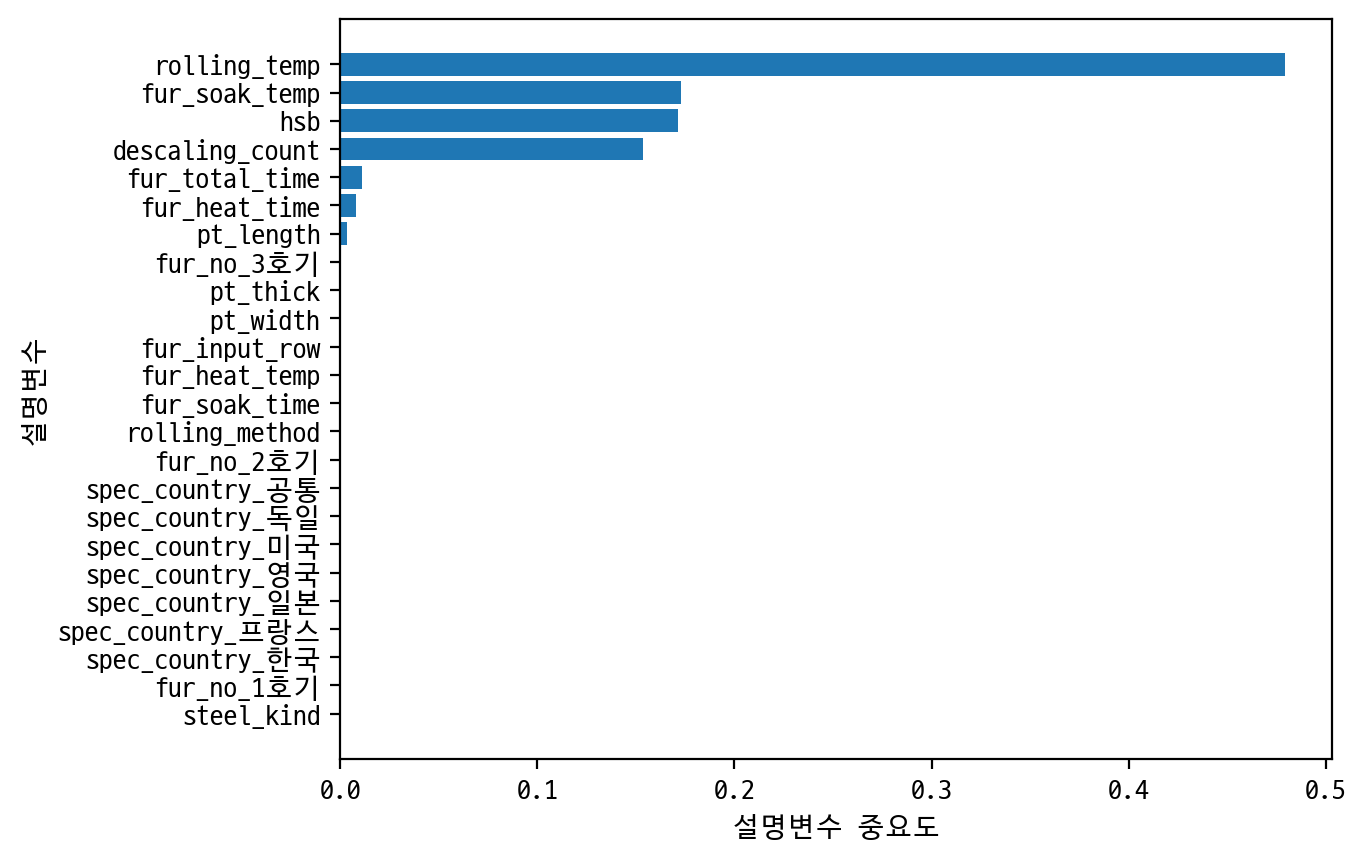

In [129]:
df_importance = pd.DataFrame()
df_importance['Feature'] = x_train.columns
df_importance['Importance'] = tree_final.feature_importances_

df_importance.sort_values("Importance", ascending = True, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y= coordinates, width = df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('설명변수 중요도')
plt.ylabel('설명변수')
plt.show()

# RandomForest

In [130]:
rf_uncust = RandomForestClassifier(random_state = 42)
rf_uncust.fit(x_train, y_train)

scores = pd.DataFrame({'uncustomized' : [rf_uncust.score(x_train, y_train),rf_uncust.score(x_test, y_test)]}, index = ['train','test'])
params = rf_uncust.get_params()
params = pd.DataFrame(data = params.items(), columns = ['Params','Uncustomized'])

print(scores)
print(params)

       uncustomized
train      1.000000
test       0.973333
                      Params Uncustomized
0                  bootstrap         True
1                  ccp_alpha          0.0
2               class_weight         None
3                  criterion         gini
4                  max_depth         None
5               max_features         sqrt
6             max_leaf_nodes         None
7                max_samples         None
8      min_impurity_decrease          0.0
9           min_samples_leaf            1
10         min_samples_split            2
11  min_weight_fraction_leaf          0.0
12              n_estimators          100
13                    n_jobs         None
14                 oob_score        False
15              random_state           42
16                   verbose            0
17                warm_start        False


In [131]:
y_pred = rf_uncust.predict(x_test)
cls_report_uncust = classification_report(y_test, y_pred, digits = 3)
cls_report_uncust = cls_reports(cls_report_uncust, 'rf')
cls_report_uncust


,precision_rf,recall_rf,f1-score_rf,support_rf
0,0.963,1.0,0.981,207
1,1.0,0.914,0.955,93
accuracy,-,-,0.973,300
macro avg,0.981,0.957,0.968,300
weighted avg,0.974,0.973,0.973,300


## 가지치기

,n_estimators,TrainAccuracy,TestAccuracy
0,10,0.995714,0.973333
1,20,0.998571,0.970000
2,30,1.000000,0.973333
3,40,1.000000,0.973333
4,50,1.000000,0.973333
5,60,1.000000,0.973333
6,70,1.000000,0.973333
7,80,1.000000,0.973333
8,90,1.000000,0.973333
9,100,1.000000,0.973333


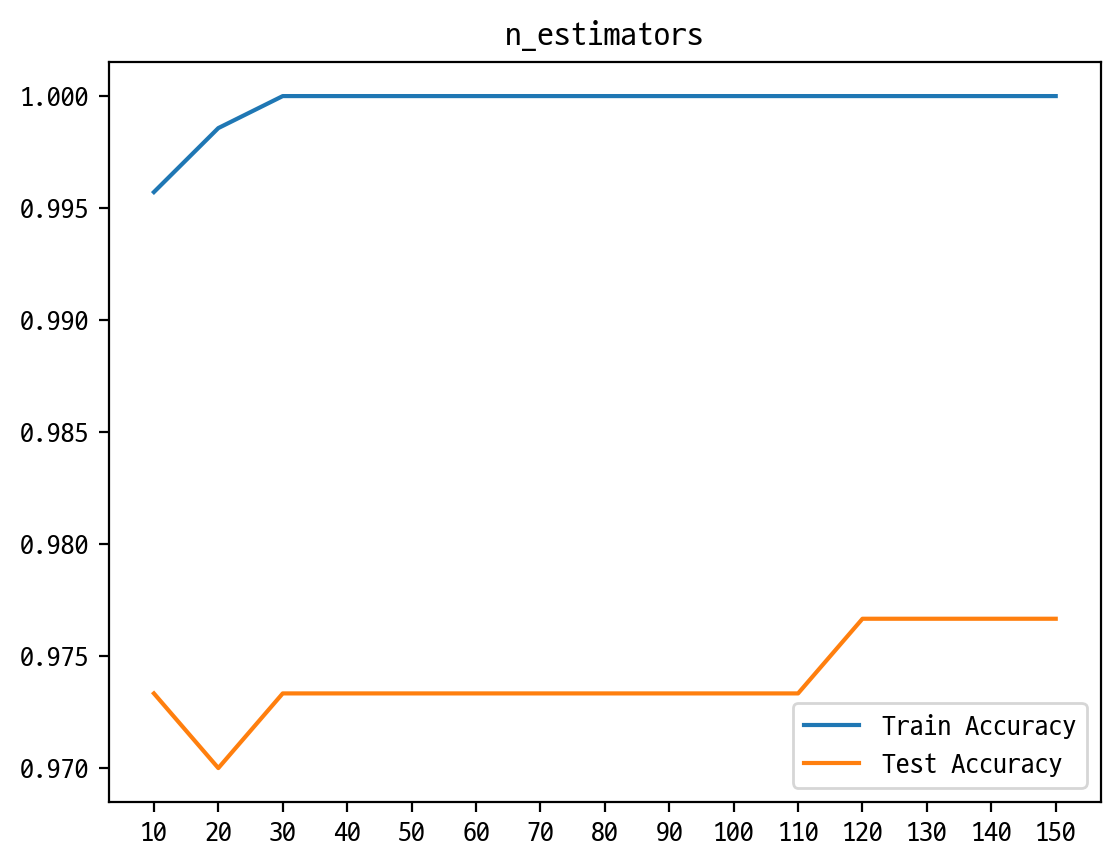

In [132]:
train_accuracy , test_accuracy = [],[]

para_n_tree = [n_tree * 10 for n_tree in range(1,16)]

for v_n_estimators in para_n_tree:
    rf = RandomForestClassifier(n_estimators = v_n_estimators , random_state= 42)
    rf.fit(x_train, y_train)
    train_accuracy.append(rf.score(x_train, y_train))
    test_accuracy.append(rf.score(x_test, y_test))

df_accuracy_n = pd.DataFrame()
df_accuracy_n['n_estimators'] = para_n_tree
df_accuracy_n['TrainAccuracy'] = train_accuracy
df_accuracy_n['TestAccuracy'] = test_accuracy

display(df_accuracy_n)

plt.plot(para_n_tree, train_accuracy, linestyle = '-', label = 'Train Accuracy')
plt.plot(para_n_tree, test_accuracy, linestyle = '-', label = 'Test Accuracy')
plt.xticks(para_n_tree)
plt.title('n_estimators')
plt.legend()


- 120 선택

,n_estimators,TrainAccuracy,TestAccuracy
0,5,0.954286,0.973333
1,6,0.957143,0.973333
2,7,0.964286,0.973333
3,8,0.977143,0.973333
4,9,0.997143,0.973333
5,10,1.000000,0.973333
6,11,1.000000,0.973333
7,12,1.000000,0.973333
8,13,1.000000,0.973333
9,14,1.000000,0.976667


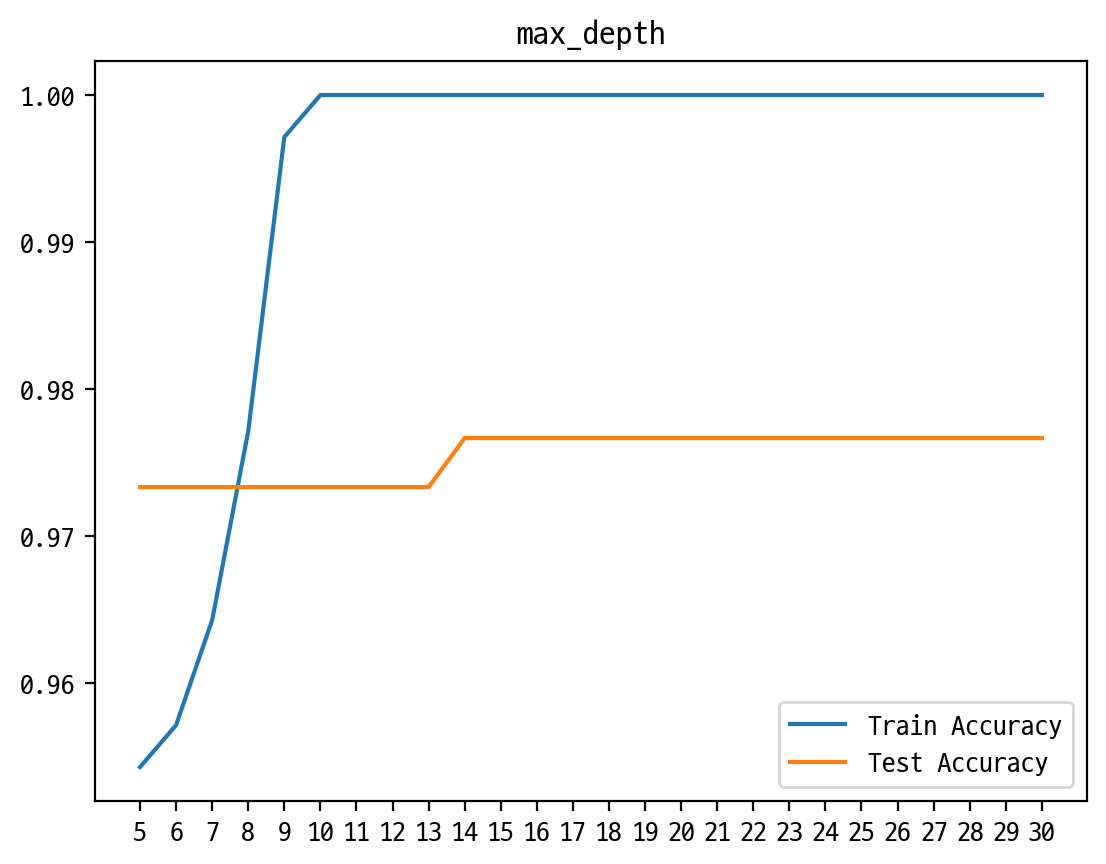

In [133]:
train_accuracy , test_accuracy = [],[]

para_depth = [depth for depth in range(5,31)]

for v_max_depth in para_depth:
    rf = RandomForestClassifier(max_depth = v_max_depth, n_estimators = 120 , random_state= 42)
    rf.fit(x_train, y_train)
    train_accuracy.append(rf.score(x_train, y_train))
    test_accuracy.append(rf.score(x_test, y_test))

df_accuarcy_depth = pd.DataFrame()
df_accuarcy_depth['n_estimators'] = para_depth
df_accuarcy_depth['TrainAccuracy'] = train_accuracy
df_accuarcy_depth['TestAccuracy'] = test_accuracy

display(df_accuarcy_depth)

plt.plot(para_depth, train_accuracy, linestyle = '-', label = 'Train Accuracy')
plt.plot(para_depth, test_accuracy, linestyle = '-', label = 'Test Accuracy')
plt.xticks(para_depth)
plt.title("max_depth")
plt.legend() 

- 14 선택

,n_estimators,TrainAccuracy,TestAccuracy
0,5,1.000000,0.973333
1,10,0.997143,0.973333
2,15,0.987143,0.973333
3,20,0.971429,0.973333
4,25,0.962857,0.973333
5,30,0.961429,0.973333
6,35,0.958571,0.973333
7,40,0.958571,0.973333
8,45,0.955714,0.973333
9,50,0.955714,0.973333


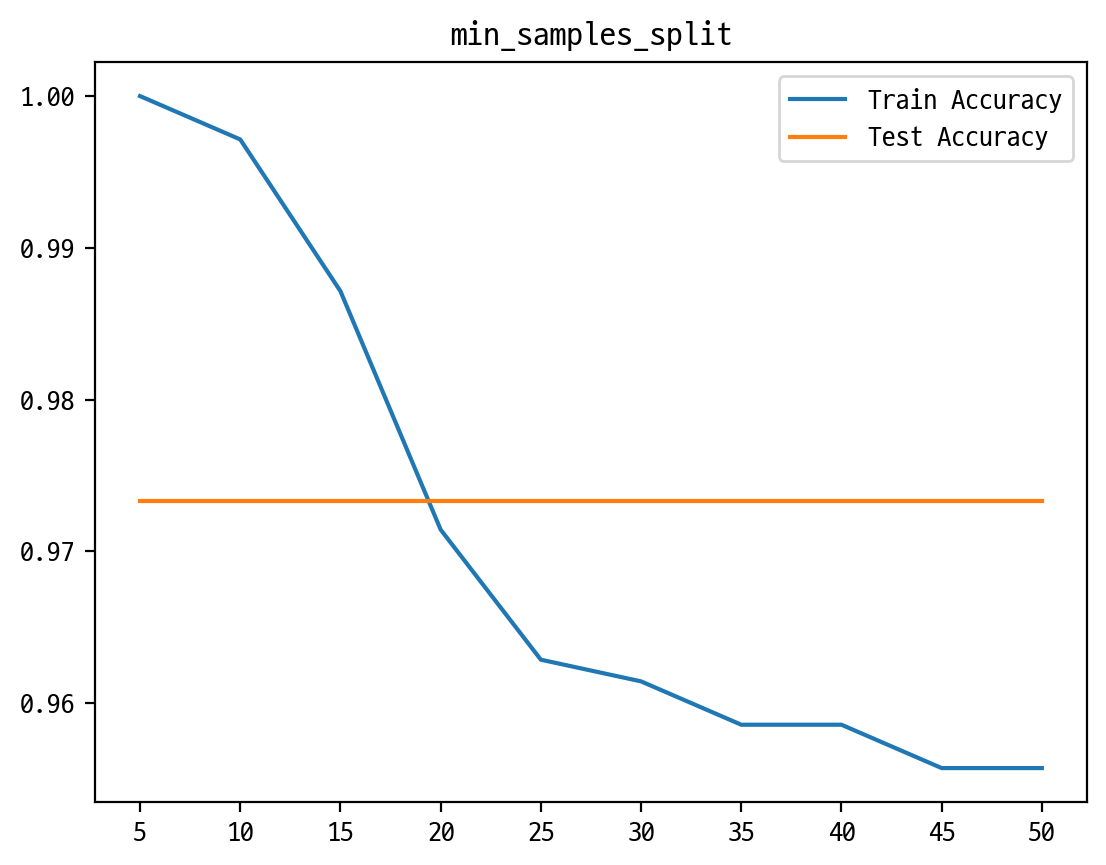

In [134]:
train_accuracy , test_accuracy = [],[]

para_split = [n_split * 5 for n_split in range(1,11)]

for v_min_samples_split in para_split:
    rf = RandomForestClassifier(max_depth = 14, n_estimators = 120 , min_samples_split = v_min_samples_split, random_state= 42)
    rf.fit(x_train, y_train)
    train_accuracy.append(rf.score(x_train, y_train))
    test_accuracy.append(rf.score(x_test, y_test))

df_accuracy_split = pd.DataFrame()
df_accuracy_split['n_estimators'] = para_split
df_accuracy_split['TrainAccuracy'] = train_accuracy
df_accuracy_split['TestAccuracy'] = test_accuracy

display(df_accuracy_split)

plt.plot(para_split, train_accuracy, linestyle = '-', label = 'Train Accuracy')
plt.plot(para_split, test_accuracy, linestyle = '-', label = 'Test Accuracy')
plt.xticks(para_split)
plt.title("min_samples_split")
plt.legend()

- 선택하지 않겠다.

,n_estimators,TrainAccuracy,TestAccuracy
0,5,0.971429,0.966667
1,10,0.940000,0.956667
2,15,0.922857,0.940000
3,20,0.910000,0.926667
4,25,0.905714,0.926667
5,30,0.877143,0.916667
6,35,0.861429,0.910000
7,40,0.860000,0.910000
8,45,0.860000,0.910000
9,50,0.860000,0.910000


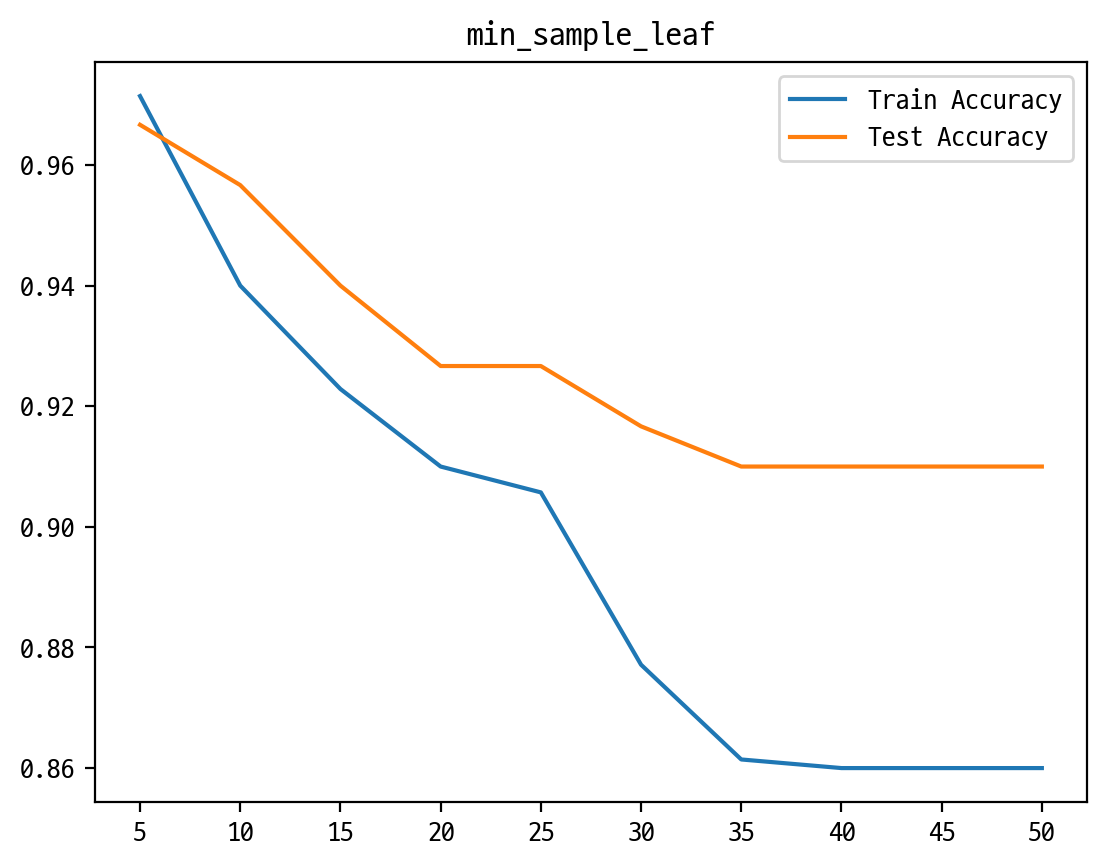

In [135]:
train_accuracy , test_accuracy = [],[]

para_leaf = [n_leaf * 5 for n_leaf in range(1,11)]

for v_min_samples_leaf in para_leaf:
    rf = RandomForestClassifier(n_estimators = 120, max_depth = 14, min_samples_leaf = v_min_samples_leaf,random_state= 42)
    rf.fit(x_train, y_train)
    train_accuracy.append(rf.score(x_train, y_train))
    test_accuracy.append(rf.score(x_test, y_test))

df_accurady_leaf = pd.DataFrame()
df_accurady_leaf['n_estimators'] = para_leaf
df_accurady_leaf['TrainAccuracy'] = train_accuracy
df_accurady_leaf['TestAccuracy'] = test_accuracy

display(df_accurady_leaf)

plt.plot(para_leaf, train_accuracy, linestyle = '-', label = 'Train Accuracy')
plt.plot(para_leaf, test_accuracy, linestyle = '-', label = 'Test Accuracy')
plt.xticks(para_leaf)
plt.title("min_sample_leaf")
plt.legend()


- 과소적합이 되고 있다. 선택하지 않겠다.

In [136]:
rf_final = RandomForestClassifier(n_estimators = 120, max_depth = 14, random_state= 42)
rf_final.fit(x_train, y_train)

y_pred = rf_final.predict(x_test)

scores['RandomForest'] = [rf_final.score(x_train , y_train),rf_final.score(x_test , y_test)]
params['RandomForest'] = rf_final.get_params().values()
print('Test Confusion matrix :\n ', confusion_matrix(y_test, y_pred))
cls_report_final = classification_report(y_test, y_pred, digits = 3)
cls_report_final_rf = cls_reports(cls_report_final, 'rf')
cls_report_final_rf

Test Confusion matrix :
  [[207   0]
 [  7  86]]


,precision_rf,recall_rf,f1-score_rf,support_rf
0,0.967,1.0,0.983,207
1,1.0,0.925,0.961,93
accuracy,-,-,0.977,300
macro avg,0.984,0.962,0.972,300
weighted avg,0.977,0.977,0.976,300


In [137]:
cls_report_uncust

,precision_rf,recall_rf,f1-score_rf,support_rf
0,0.963,1.0,0.981,207
1,1.0,0.914,0.955,93
accuracy,-,-,0.973,300
macro avg,0.981,0.957,0.968,300
weighted avg,0.974,0.973,0.973,300


In [138]:
cls_report_final

'              precision    recall  f1-score   support\n\n           0      0.967     1.000     0.983       207\n           1      1.000     0.925     0.961        93\n\n    accuracy                          0.977       300\n   macro avg      0.984     0.962     0.972       300\nweighted avg      0.977     0.977     0.976       300\n'

In [139]:
print(scores)
print(params)

       uncustomized  RandomForest
train      1.000000      1.000000
test       0.973333      0.976667
                      Params Uncustomized RandomForest
0                  bootstrap         True         True
1                  ccp_alpha          0.0          0.0
2               class_weight         None         None
3                  criterion         gini         gini
4                  max_depth         None           14
5               max_features         sqrt         sqrt
6             max_leaf_nodes         None         None
7                max_samples         None         None
8      min_impurity_decrease          0.0          0.0
9           min_samples_leaf            1            1
10         min_samples_split            2            2
11  min_weight_fraction_leaf          0.0          0.0
12              n_estimators          100          120
13                    n_jobs         None         None
14                 oob_score        False        False
15              ra

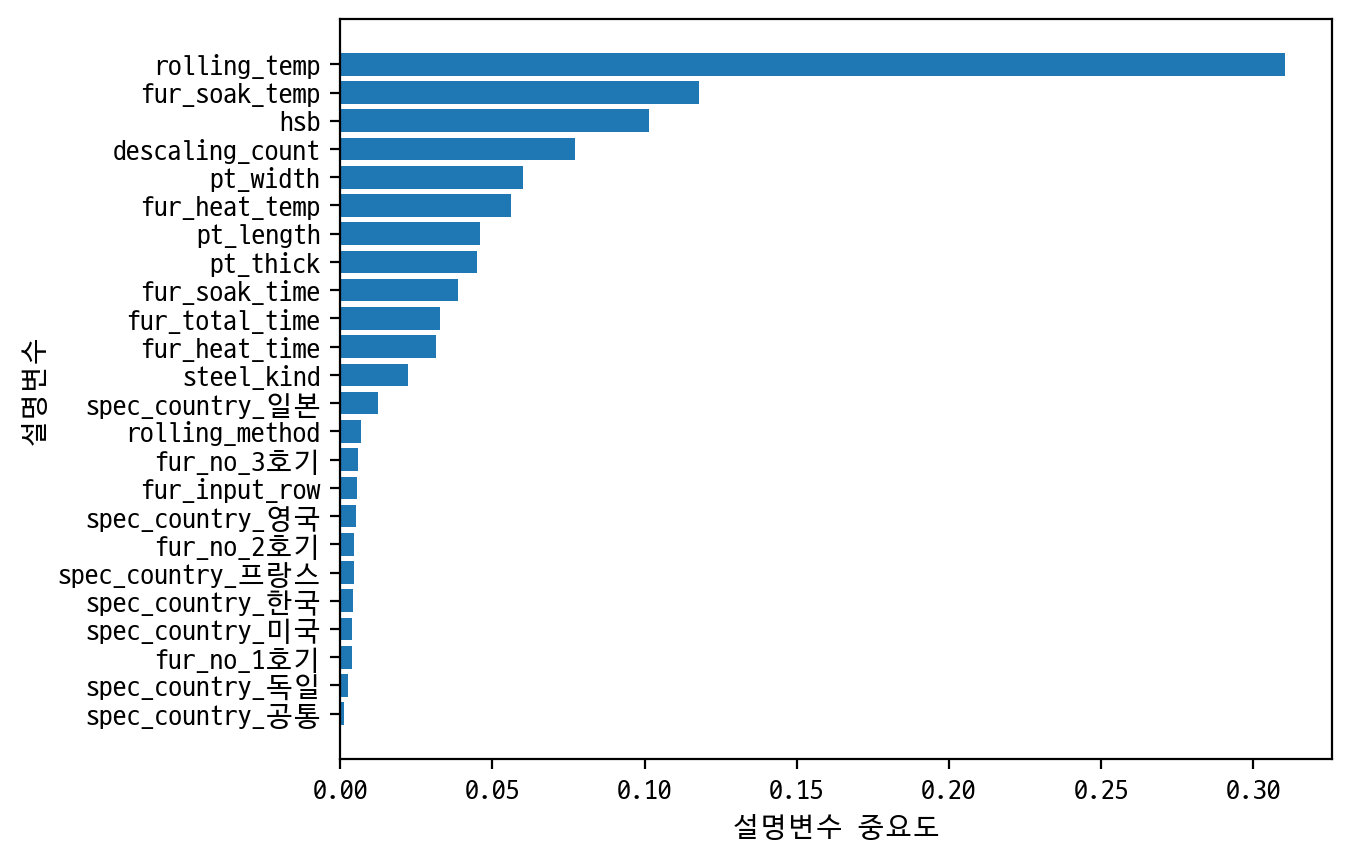

In [140]:
df_importance = pd.DataFrame()
df_importance['Feature'] = x_train.columns
df_importance['Importance'] = rf_final.feature_importances_

df_importance.sort_values("Importance", ascending = True, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y= coordinates, width = df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('설명변수 중요도')
plt.ylabel('설명변수')
plt.show()

# GBM

In [141]:
gb_uncust = GradientBoostingClassifier(random_state = 42)
gb_uncust.fit(x_train, y_train)

scores = pd.DataFrame({'uncustomized' : [gb_uncust.score(x_train, y_train),gb_uncust.score(x_test, y_test)]}, index = ['train','test'])
params = gb_uncust.get_params()
params = pd.DataFrame(data = params.items(), columns = ['Params','Uncustomized'])

print(scores)
print(params)

       uncustomized
train      1.000000
test       0.996667
                      Params  Uncustomized
0                  ccp_alpha           0.0
1                  criterion  friedman_mse
2                       init          None
3              learning_rate           0.1
4                       loss      log_loss
5                  max_depth             3
6               max_features          None
7             max_leaf_nodes          None
8      min_impurity_decrease           0.0
9           min_samples_leaf             1
10         min_samples_split             2
11  min_weight_fraction_leaf           0.0
12              n_estimators           100
13          n_iter_no_change          None
14              random_state            42
15                 subsample           1.0
16                       tol        0.0001
17       validation_fraction           0.1
18                   verbose             0
19                warm_start         False


In [142]:
y_pred = gb_uncust.predict(x_test)
cls_report_uncust = classification_report(y_test, y_pred, digits = 3)
cls_report_uncust_gb = cls_reports(cls_report_uncust, 'GB')
cls_report_uncust_gb

,precision_GB,recall_GB,f1-score_GB,support_GB
0,0.995,1.0,0.998,207
1,1.0,0.989,0.995,93
accuracy,-,-,0.997,300
macro avg,0.998,0.995,0.996,300
weighted avg,0.997,0.997,0.997,300


,LearningRate,TrainAccuracy,TestAccuracy
0,0.01,0.954286,0.973333
1,0.02,0.960000,0.980000
2,0.03,0.961429,0.980000
3,0.04,0.988571,0.986667
4,0.05,0.994286,0.993333
5,0.06,1.000000,0.993333
6,0.07,1.000000,0.996667
7,0.08,1.000000,0.996667
8,0.09,1.000000,0.993333
9,0.10,1.000000,0.996667


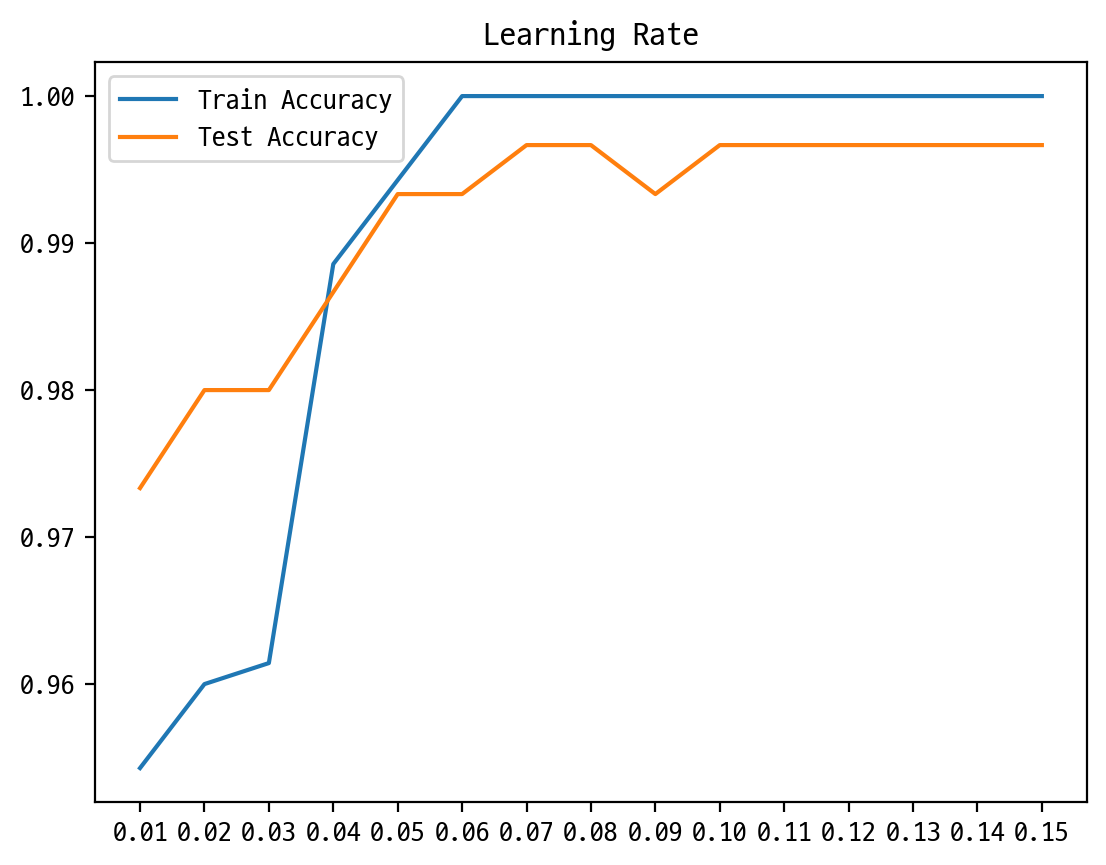

In [143]:
train_accuracy , test_accuracy = [],[]

para_lr = [lr * 0.01 for lr in range(1,16)]

for v_learning_rate in para_lr:
    gb = GradientBoostingClassifier(learning_rate = v_learning_rate , random_state= 42)
    gb.fit(x_train, y_train)
    train_accuracy.append(gb.score(x_train, y_train))
    test_accuracy.append(gb.score(x_test, y_test))

df_accuracy_lr = pd.DataFrame()
df_accuracy_lr['LearningRate'] = para_lr
df_accuracy_lr['TrainAccuracy'] = train_accuracy
df_accuracy_lr['TestAccuracy'] = test_accuracy

display(df_accuracy_lr)

plt.plot(para_lr, train_accuracy, linestyle = '-', label = 'Train Accuracy')
plt.plot(para_lr, test_accuracy, linestyle = '-', label = 'Test Accuracy')
plt.xticks(para_lr)
plt.title('Learning Rate')
plt.legend()


- 0.07

,LearningRate,TrainAccuracy,TestAccuracy
0,10,0.954286,0.973333
1,20,0.954286,0.973333
2,30,0.960000,0.980000
3,40,0.961429,0.980000
4,50,0.984286,0.986667
5,60,0.995714,0.993333
6,70,0.997143,0.993333
7,80,0.994286,0.993333
8,90,1.000000,0.993333
9,100,1.000000,0.996667


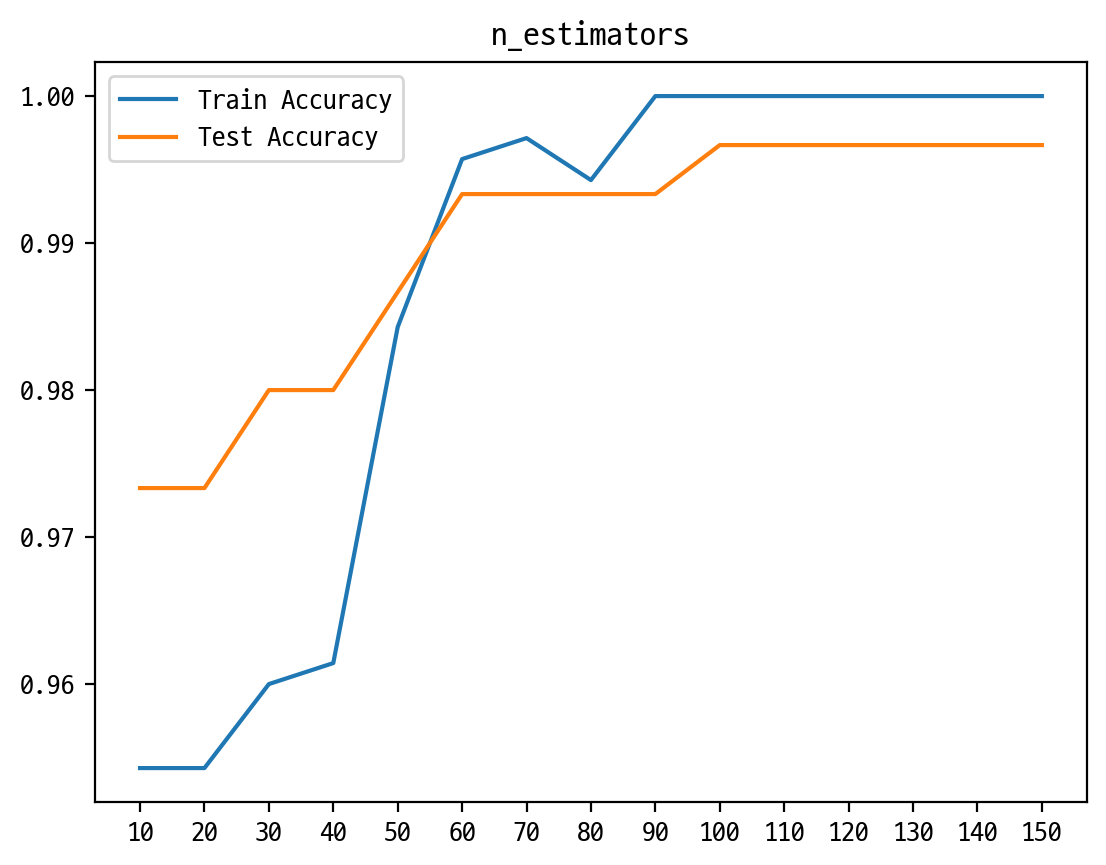

In [144]:
train_accuracy , test_accuracy = [],[]

para_n_tree = [n_tree * 10 for n_tree in range(1,16)]

for v_n_estimators in para_n_tree:
    gb = GradientBoostingClassifier(n_estimators = v_n_estimators, learning_rate = 0.07 , random_state= 42)
    gb.fit(x_train, y_train)
    train_accuracy.append(gb.score(x_train, y_train))
    test_accuracy.append(gb.score(x_test, y_test))

df_accuracy_n = pd.DataFrame()
df_accuracy_n['LearningRate'] = para_n_tree
df_accuracy_n['TrainAccuracy'] = train_accuracy
df_accuracy_n['TestAccuracy'] = test_accuracy

display(df_accuracy_n)

plt.plot(para_n_tree, train_accuracy, linestyle = '-', label = 'Train Accuracy')
plt.plot(para_n_tree, test_accuracy, linestyle = '-', label = 'Test Accuracy')
plt.xticks(para_n_tree)
plt.title('n_estimators')
plt.legend()


- 100

,MaxDepth,TrainAccuracy,TestAccuracy
0,1,0.954286,0.973333
1,2,0.981429,0.990000
2,3,1.000000,0.996667
3,4,1.000000,0.993333
4,5,1.000000,0.993333
5,6,1.000000,0.993333
6,7,1.000000,0.993333
7,8,1.000000,0.996667
8,9,1.000000,0.993333
9,10,1.000000,0.996667


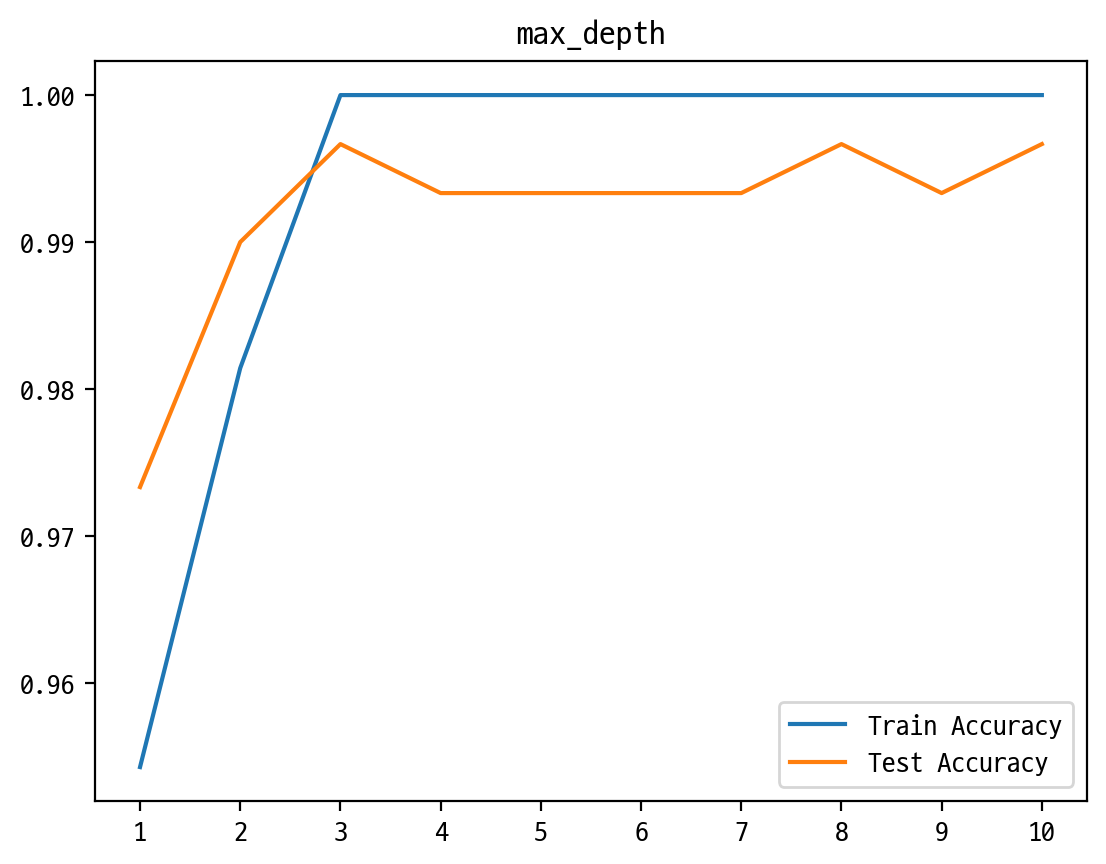

In [145]:
train_accuracy , test_accuracy = [],[]

para_depth = [depth for depth in range(1,11)]

for v_max_depth in para_depth:
    gb = GradientBoostingClassifier(max_depth = v_max_depth, n_estimators = 100, learning_rate = 0.07 , random_state= 42)
    gb.fit(x_train, y_train)
    train_accuracy.append(gb.score(x_train, y_train))
    test_accuracy.append(gb.score(x_test, y_test))

df_accuracy_depth = pd.DataFrame()
df_accuracy_depth['MaxDepth'] = para_depth
df_accuracy_depth['TrainAccuracy'] = train_accuracy
df_accuracy_depth['TestAccuracy'] = test_accuracy

display(df_accuracy_depth)

plt.plot(para_depth, train_accuracy, linestyle = '-', label = 'Train Accuracy')
plt.plot(para_depth, test_accuracy, linestyle = '-', label = 'Test Accuracy')
plt.xticks(para_depth)
plt.title('max_depth')
plt.legend()


- 8

,MinSamplesSplit,TrainAccuracy,TestAccuracy
0,2,1.0,0.996667
1,4,1.0,0.996667
2,6,1.0,0.993333
3,8,1.0,0.993333
4,10,1.0,0.993333
5,12,1.0,0.993333
6,14,1.0,0.996667
7,16,1.0,0.996667
8,18,1.0,0.996667
9,20,1.0,0.996667


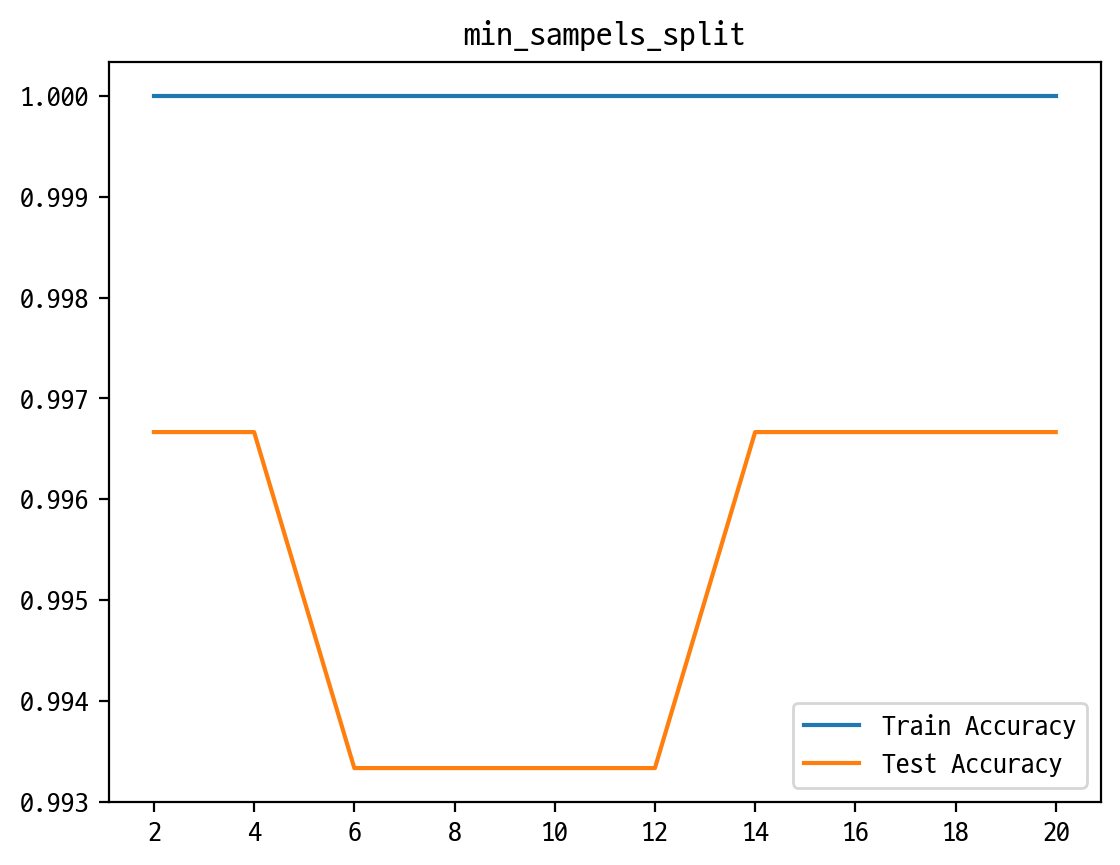

In [146]:
train_accuracy , test_accuracy = [],[]

para_split = [n_split * 2 for n_split in range(1,11)]

for v_min_samples_split in para_split:
    gb = GradientBoostingClassifier(min_samples_split = v_min_samples_split, max_depth = 8, n_estimators = 100, learning_rate = 0.07 , random_state= 42)
    gb.fit(x_train, y_train)
    train_accuracy.append(gb.score(x_train, y_train))
    test_accuracy.append(gb.score(x_test, y_test))

df_accuracy_split = pd.DataFrame()
df_accuracy_split['MinSamplesSplit'] = para_split
df_accuracy_split['TrainAccuracy'] = train_accuracy
df_accuracy_split['TestAccuracy'] = test_accuracy

display(df_accuracy_split)

plt.plot(para_split, train_accuracy, linestyle = '-', label = 'Train Accuracy')
plt.plot(para_split, test_accuracy, linestyle = '-', label = 'Test Accuracy')
plt.xticks(para_split)
plt.title('min_sampels_split')
plt.legend()


- 선택하지 않겠다!

,MinSamplesLeaf,TrainAccuracy,TestAccuracy
0,2,1.0,0.996667
1,4,1.0,0.993333
2,6,1.0,0.986667
3,8,1.0,0.986667
4,10,1.0,0.986667
5,12,1.0,0.986667
6,14,1.0,0.986667
7,16,1.0,0.990000
8,18,1.0,0.986667
9,20,1.0,0.986667


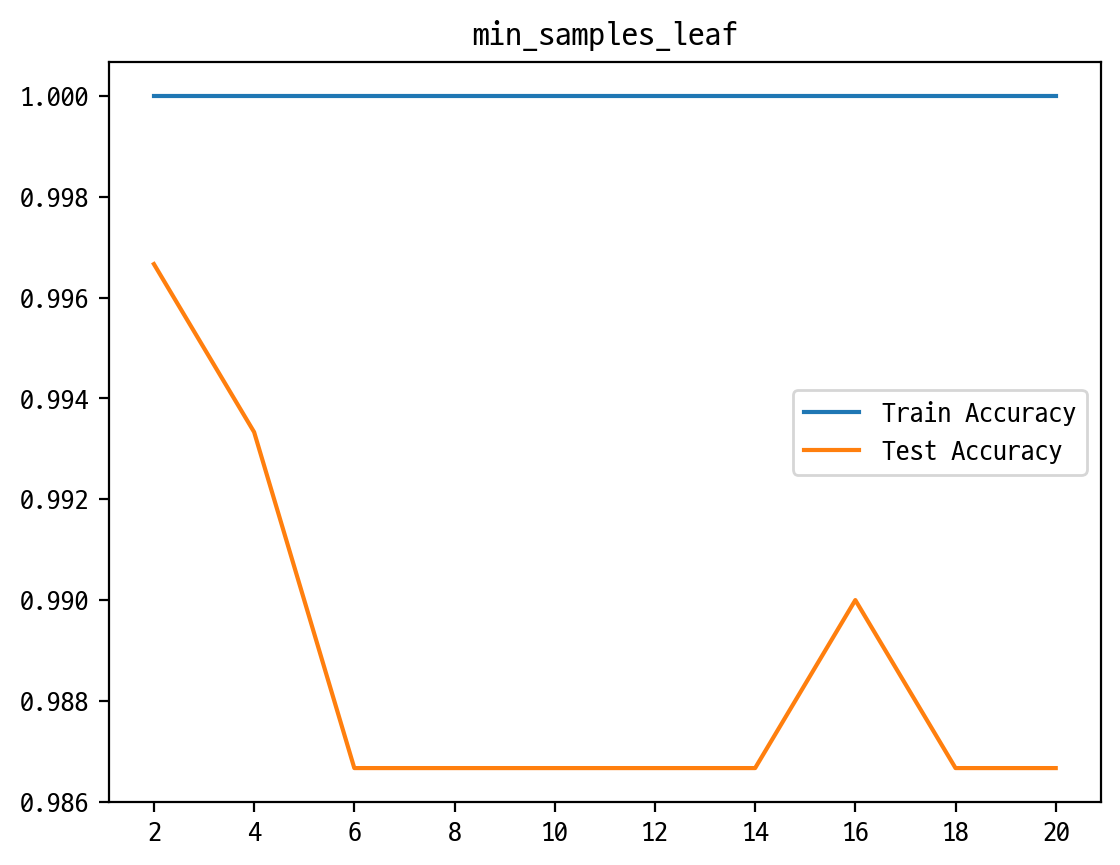

In [147]:
train_accuracy , test_accuracy = [],[]

para_leaf = [n_leaf * 2 for n_leaf in range(1,11)]

for v_min_samples_leaf in para_leaf:
    gb = GradientBoostingClassifier(min_samples_leaf = v_min_samples_leaf, max_depth = 8, n_estimators = 100, learning_rate = 0.07 , random_state= 42)
    gb.fit(x_train, y_train)
    train_accuracy.append(gb.score(x_train, y_train))
    test_accuracy.append(gb.score(x_test, y_test))

df_accuracy_leaf = pd.DataFrame()
df_accuracy_leaf['MinSamplesLeaf'] = para_leaf
df_accuracy_leaf['TrainAccuracy'] = train_accuracy
df_accuracy_leaf['TestAccuracy'] = test_accuracy

display(df_accuracy_leaf)

plt.plot(para_leaf, train_accuracy, linestyle = '-', label = 'Train Accuracy')
plt.plot(para_leaf, test_accuracy, linestyle = '-', label = 'Test Accuracy')
plt.xticks(para_leaf)
plt.title('min_samples_leaf')
plt.legend()


- 선택하지 않겠다.

In [148]:
gb_final = GradientBoostingClassifier(max_depth = 8, n_estimators = 100, learning_rate = 0.07 , random_state= 42)
gb_final.fit(x_train, y_train)

y_pred = gb_final.predict(x_test)

scores['GradientBoosting'] = [gb_final.score(x_train , y_train),gb_final.score(x_test , y_test)]
params['GradientBoosting'] = gb_final.get_params().values()
print('Test Confusion matrix :\n ', confusion_matrix(y_test, y_pred))
cls_report_final = classification_report(y_test, y_pred, digits = 3)
cls_report_final_gb = cls_reports(cls_report_final, 'gb')

Test Confusion matrix :
  [[207   0]
 [  1  92]]


In [149]:
cls_report_uncust_gb

,precision_GB,recall_GB,f1-score_GB,support_GB
0,0.995,1.0,0.998,207
1,1.0,0.989,0.995,93
accuracy,-,-,0.997,300
macro avg,0.998,0.995,0.996,300
weighted avg,0.997,0.997,0.997,300


In [150]:
cls_report_final_gb

,precision_gb,recall_gb,f1-score_gb,support_gb
0,0.995,1.0,0.998,207
1,1.0,0.989,0.995,93
accuracy,-,-,0.997,300
macro avg,0.998,0.995,0.996,300
weighted avg,0.997,0.997,0.997,300


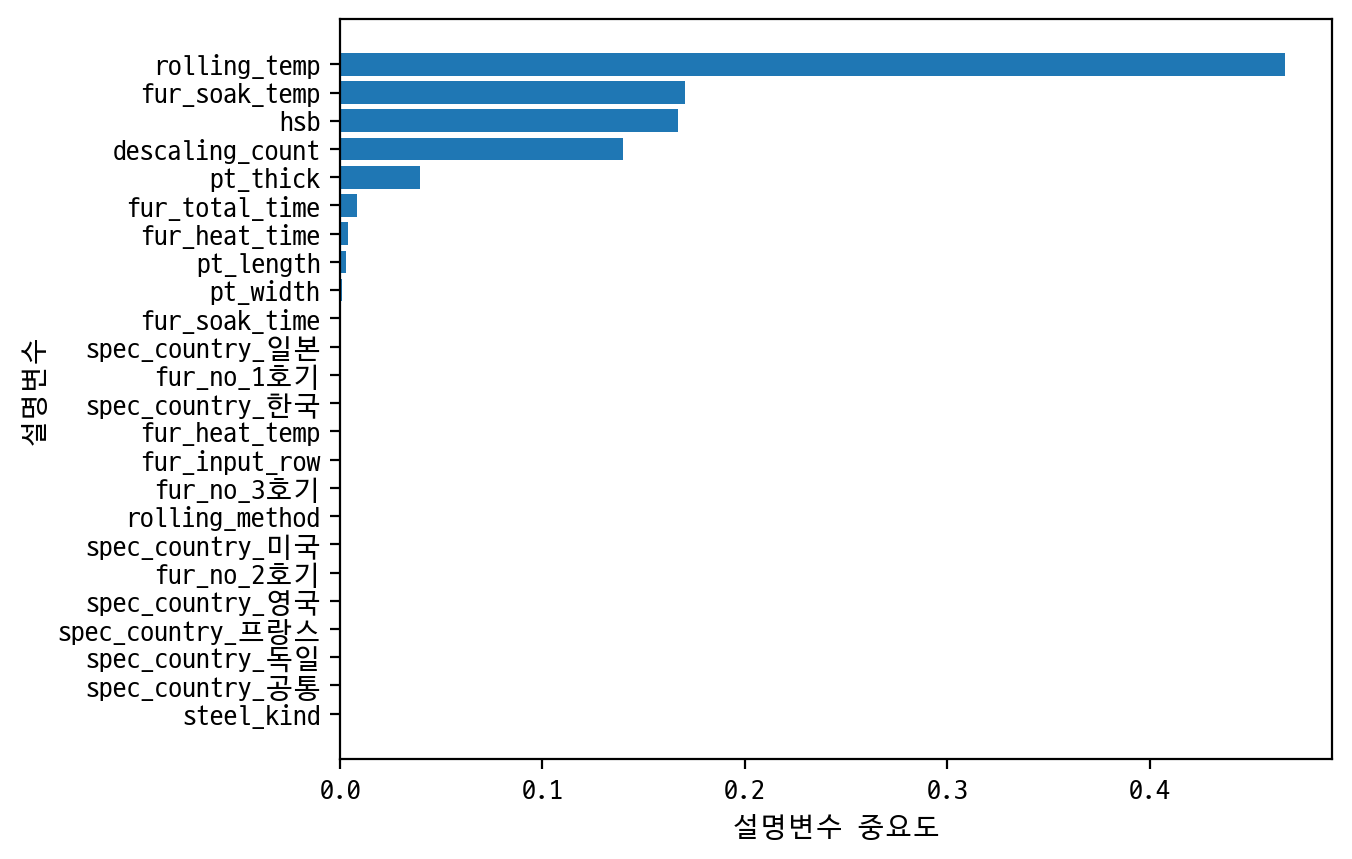

In [151]:
df_importance = pd.DataFrame()
df_importance['Feature'] = x_test.columns
df_importance['Importance'] = gb_final.feature_importances_

df_importance.sort_values("Importance", ascending = True, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y= coordinates, width = df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('설명변수 중요도')
plt.ylabel('설명변수')
plt.show()

# XGBM

# XGBM

In [152]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

xgboost_uncust = XGBClassifier(random_state = 42)
xgboost_uncust.fit(x_train, y_train)

print(xgboost_uncust.score(x_train, y_train))
print(xgboost_uncust.score(x_test,y_test))
y_pred = xgboost_uncust.predict(x_test)

print(classification_report(y_test, y_pred))
print(xgboost_uncust.score(x_test,y_test))

scores = pd.DataFrame({'uncustomized' : [xgboost_uncust.score(x_train, y_train),xgboost_uncust.score(x_test, y_test)]}, index = ['train','test'])
params = xgboost_uncust.get_params()
params = pd.DataFrame(data = params.items(), columns = ['Params','Uncustomized'])

print(scores)
print(params)
y_pred = xgboost_uncust.predict(x_test)
cls_report_uncust = classification_report(y_test, y_pred, digits = 3)
cls_report_uncust_xgb = cls_reports(cls_report_uncust, 'xgb')
cls_report_uncust_xgb

1.0
0.9866666666666667
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       207
           1       1.00      0.96      0.98        93

    accuracy                           0.99       300
   macro avg       0.99      0.98      0.98       300
weighted avg       0.99      0.99      0.99       300

0.9866666666666667
       uncustomized
train      1.000000
test       0.986667
                     Params     Uncustomized
0                 objective  binary:logistic
1         use_label_encoder             None
2                base_score             None
3                   booster             None
4                 callbacks             None
5         colsample_bylevel             None
6          colsample_bynode             None
7          colsample_bytree             None
8     early_stopping_rounds             None
9        enable_categorical            False
10              eval_metric             None
11            feature_types    

,precision_xgb,recall_xgb,f1-score_xgb,support_xgb
0,0.981,1.0,0.990,207
1,1.0,0.957,0.978,93
accuracy,-,-,0.987,300
macro avg,0.991,0.978,0.984,300
weighted avg,0.987,0.987,0.987,300


,n_estimators,TrainAccuracy,TestAccuracy
0,10,0.994286,0.986667
1,20,0.997143,0.986667
2,30,0.997143,0.986667
3,40,1.000000,0.986667
4,50,1.000000,0.986667
5,60,1.000000,0.986667
6,70,1.000000,0.986667
7,80,1.000000,0.986667
8,90,1.000000,0.986667
9,100,1.000000,0.986667


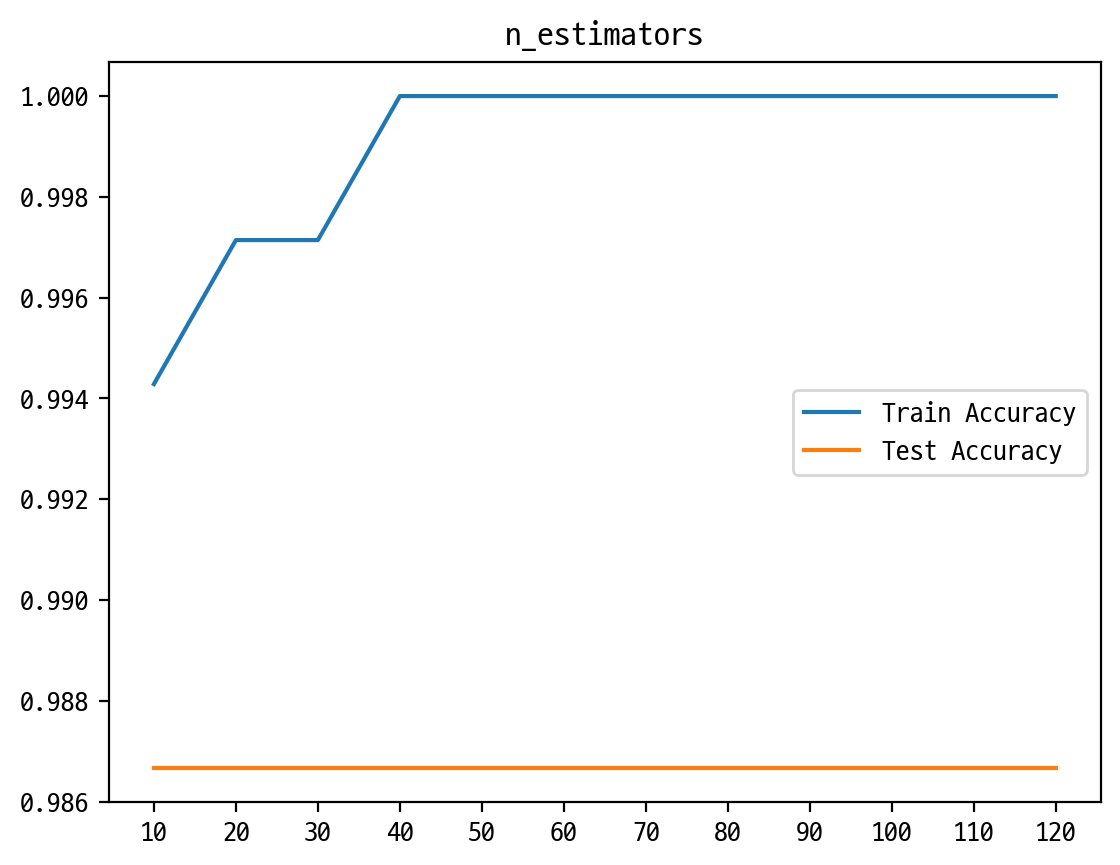

In [153]:
train_accuracy , test_accuracy = [],[]

para_n_estimators = [n * 10 for n in range(1,13)]

for v_n_estimators in para_n_estimators:
    xgb = XGBClassifier(n_estimators = v_n_estimators , random_state= 42)
    xgb.fit(x_train, y_train)
    train_accuracy.append(xgb.score(x_train, y_train))
    test_accuracy.append(xgb.score(x_test, y_test))

df_accuracy_n = pd.DataFrame()
df_accuracy_n['n_estimators'] = para_n_estimators
df_accuracy_n['TrainAccuracy'] = train_accuracy
df_accuracy_n['TestAccuracy'] = test_accuracy

display(df_accuracy_n)

plt.plot(para_n_estimators, train_accuracy, linestyle = '-', label = 'Train Accuracy')
plt.plot(para_n_estimators, test_accuracy, linestyle = '-', label = 'Test Accuracy')
plt.xticks(para_n_estimators)
plt.title('n_estimators')
plt.legend()


- 40개

,LearningRate,TrainAccuracy,TestAccuracy
0,0.10,0.994286,0.986667
1,0.11,0.994286,0.986667
2,0.12,0.994286,0.986667
3,0.13,0.995714,0.986667
4,0.14,0.995714,0.986667
5,0.15,0.997143,0.986667
6,0.16,0.997143,0.986667
7,0.17,0.997143,0.986667
8,0.18,0.997143,0.986667
9,0.19,0.997143,0.986667


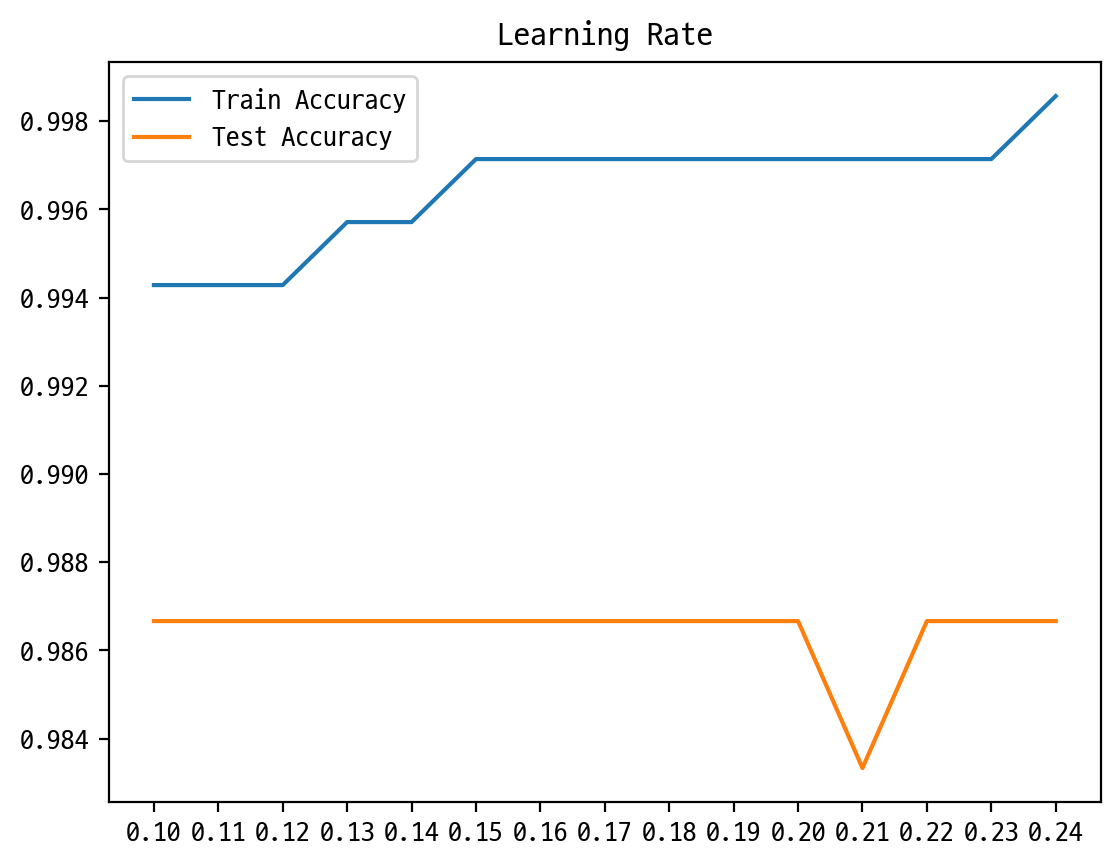

In [154]:
train_accuracy , test_accuracy = [],[]

para_lr = [lr * 0.01 for lr in range(10,25)]

for v_learning_rate in para_lr:
    xgb = XGBClassifier(learning_rate = v_learning_rate,n_estimators = 40 , random_state= 42)
    xgb.fit(x_train, y_train)
    train_accuracy.append(xgb.score(x_train, y_train))
    test_accuracy.append(xgb.score(x_test, y_test))

df_accuracy_lr = pd.DataFrame()
df_accuracy_lr['LearningRate'] = para_lr
df_accuracy_lr['TrainAccuracy'] = train_accuracy
df_accuracy_lr['TestAccuracy'] = test_accuracy

display(df_accuracy_lr)

plt.plot(para_lr, train_accuracy, linestyle = '-', label = 'Train Accuracy')
plt.plot(para_lr, test_accuracy, linestyle = '-', label = 'Test Accuracy')
plt.xticks(para_lr)
plt.title('Learning Rate')
plt.legend()


- 0.15

,MaxDepth,TrainAccuracy,TestAccuracy
0,1,0.997143,0.986667
1,2,0.997143,0.986667
2,3,0.997143,0.986667
3,4,0.997143,0.986667
4,5,0.997143,0.986667
5,6,0.997143,0.986667
6,7,0.997143,0.986667
7,8,0.997143,0.986667
8,9,0.997143,0.986667
9,10,0.997143,0.986667


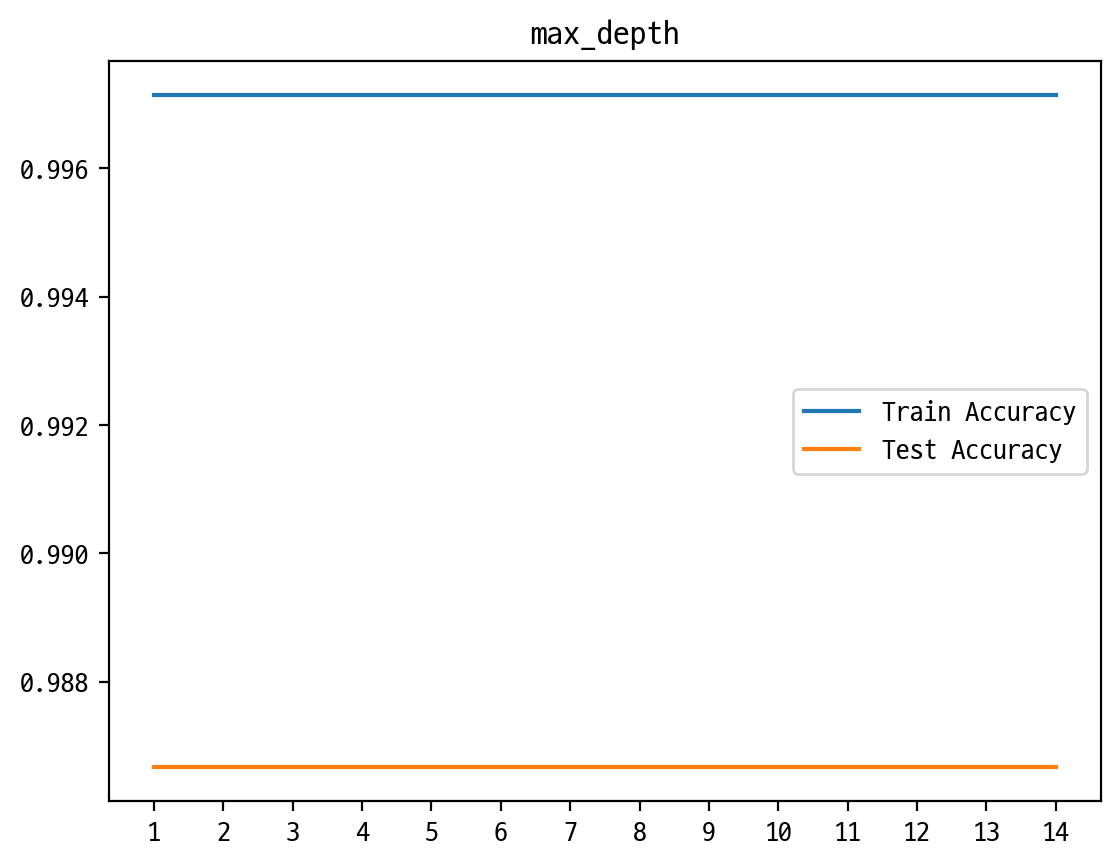

In [155]:
train_accuracy , test_accuracy = [],[]

para_depth = [depth for depth in range(1,15)]

for v_mat_depth in para_depth:
    xgb = XGBClassifier(max_depth = v_max_depth , learning_rate = 0.15,n_estimators = 40 , random_state= 42)
    xgb.fit(x_train, y_train)
    train_accuracy.append(xgb.score(x_train, y_train))
    test_accuracy.append(xgb.score(x_test, y_test))

df_accuracy_depth = pd.DataFrame()
df_accuracy_depth['MaxDepth'] = para_depth
df_accuracy_depth['TrainAccuracy'] = train_accuracy
df_accuracy_depth['TestAccuracy'] = test_accuracy

display(df_accuracy_depth)

plt.plot(para_depth, train_accuracy, linestyle = '-', label = 'Train Accuracy')
plt.plot(para_depth, test_accuracy, linestyle = '-', label = 'Test Accuracy')
plt.xticks(para_depth)
plt.title('max_depth')
plt.legend()


- 선택하지 않도록 하겠다.

In [156]:
xgb_final = XGBClassifier(learning_rate = 0.15,n_estimators = 40 , random_state= 42)
xgb_final.fit(x_train, y_train)

y_pred = xgb_final.predict(x_test)

scores['XGBClassifier'] = [xgb_final.score(x_train , y_train),xgb_final.score(x_test , y_test)]
params['XGBClassifier'] = xgb_final.get_params().values()
print('Test Confusion matrix :\n ', confusion_matrix(y_test, y_pred))
cls_report_final = classification_report(y_test, y_pred, digits = 3)
cls_report_final_xgb = cls_reports(cls_report_final, 'xgb')
cls_report_final_xgb

Test Confusion matrix :
  [[207   0]
 [  4  89]]


,precision_xgb,recall_xgb,f1-score_xgb,support_xgb
0,0.981,1.0,0.990,207
1,1.0,0.957,0.978,93
accuracy,-,-,0.987,300
macro avg,0.991,0.978,0.984,300
weighted avg,0.987,0.987,0.987,300


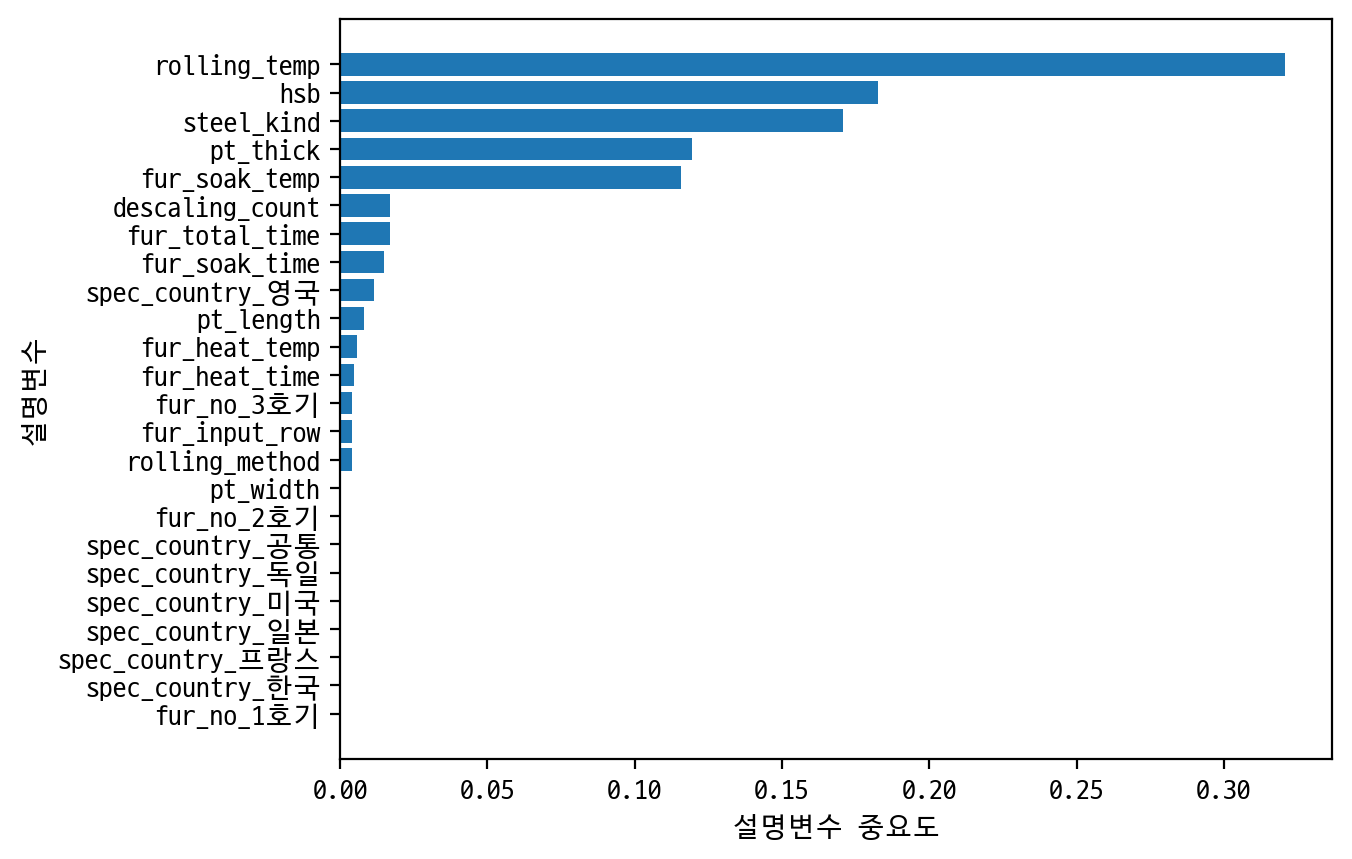

In [157]:
df_importance = pd.DataFrame()
df_importance['Feature'] = x_test.columns
df_importance['Importance'] = xgb_final.feature_importances_

df_importance.sort_values("Importance", ascending = True, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y= coordinates, width = df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('설명변수 중요도')
plt.ylabel('설명변수')
plt.show()

# Light GBM

In [158]:
lgbm_uncust = LGBMClassifier(random_state = 42)
lgbm_uncust.fit(x_train, y_train)

print(lgbm_uncust.score(x_train, y_train))
print(lgbm_uncust.score(x_test,y_test))
y_pred = lgbm_uncust.predict(x_test)

print(classification_report(y_test, y_pred))
print(lgbm_uncust.score(x_test,y_test))

scores = pd.DataFrame({'uncustomized' : [lgbm_uncust.score(x_train, y_train),lgbm_uncust.score(x_test, y_test)]}, index = ['train','test'])
params = lgbm_uncust.get_params()
params = pd.DataFrame(data = params.items(), columns = ['Params','Uncustomized'])

print(scores)
print(params)

[LightGBM] [Info] Number of positive: 217, number of negative: 483
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000521 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.310000 -> initscore=-0.800119
[LightGBM] [Info] Start training from score -0.800119
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[LightGBM] [Info] Number of positive: 217, number of negative: 483
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000639 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.310000 -> initscore=-0.800119
[LightGBM] [Info] Start training from score -0.800119
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

,n_estimators,TrainAccuracy,TestAccuracy
0,10,0.982857,0.986667
1,20,0.994286,0.990000
2,30,0.995714,0.990000
3,40,1.000000,0.986667
4,50,1.000000,0.993333
5,60,1.000000,0.993333
6,70,1.000000,0.993333
7,80,1.000000,0.993333
8,90,1.000000,0.993333
9,100,1.000000,0.993333


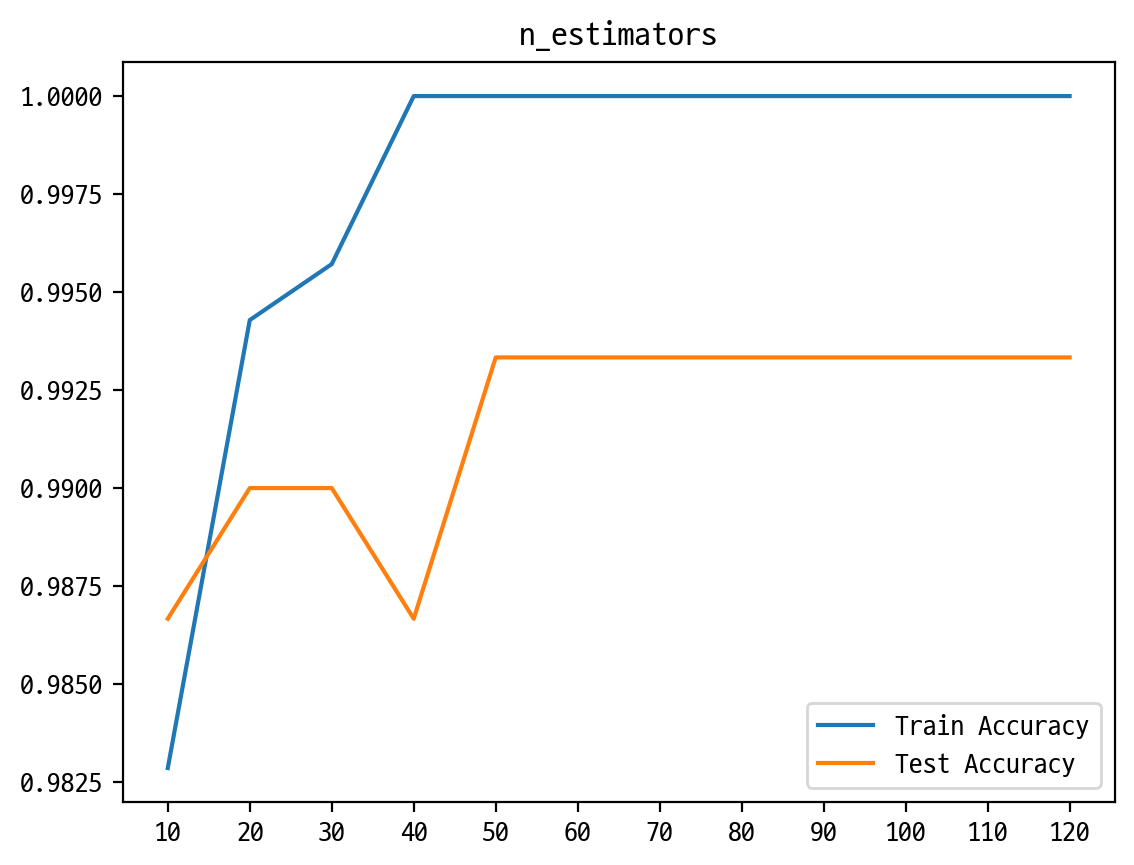

In [164]:
train_accuracy , test_accuracy = [],[]

para_n_estimators = [n * 10 for n in range(1,13)]

for v_n_estimators in para_n_estimators:
    lgbm = LGBMClassifier(n_estimators = v_n_estimators , random_state= 42)
    lgbm.fit(x_train, y_train)
    train_accuracy.append(lgbm.score(x_train, y_train))
    test_accuracy.append(lgbm.score(x_test, y_test))

df_accuracy_n = pd.DataFrame()
df_accuracy_n['n_estimators'] = para_n_estimators
df_accuracy_n['TrainAccuracy'] = train_accuracy
df_accuracy_n['TestAccuracy'] = test_accuracy

display(df_accuracy_n)

plt.plot(para_n_estimators, train_accuracy, linestyle = '-', label = 'Train Accuracy')
plt.plot(para_n_estimators, test_accuracy, linestyle = '-', label = 'Test Accuracy')
plt.xticks(para_n_estimators)
plt.legend()
plt.title('n_estimators')
plt.show()


- 50개

[LightGBM] [Info] Number of positive: 217, number of negative: 483
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000654 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.310000 -> initscore=-0.800119
[LightGBM] [Info] Start training from score -0.800119
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

,LearningRate,TrainAccuracy,TestAccuracy
0,0.10,1.0,0.993333
1,0.11,1.0,0.993333
2,0.12,1.0,0.993333
3,0.13,1.0,0.993333
4,0.14,1.0,0.993333
5,0.15,1.0,0.993333
6,0.16,1.0,0.993333
7,0.17,1.0,0.993333
8,0.18,1.0,0.993333
9,0.19,1.0,0.993333


Text(0.5, 1.0, 'Learning Rate')

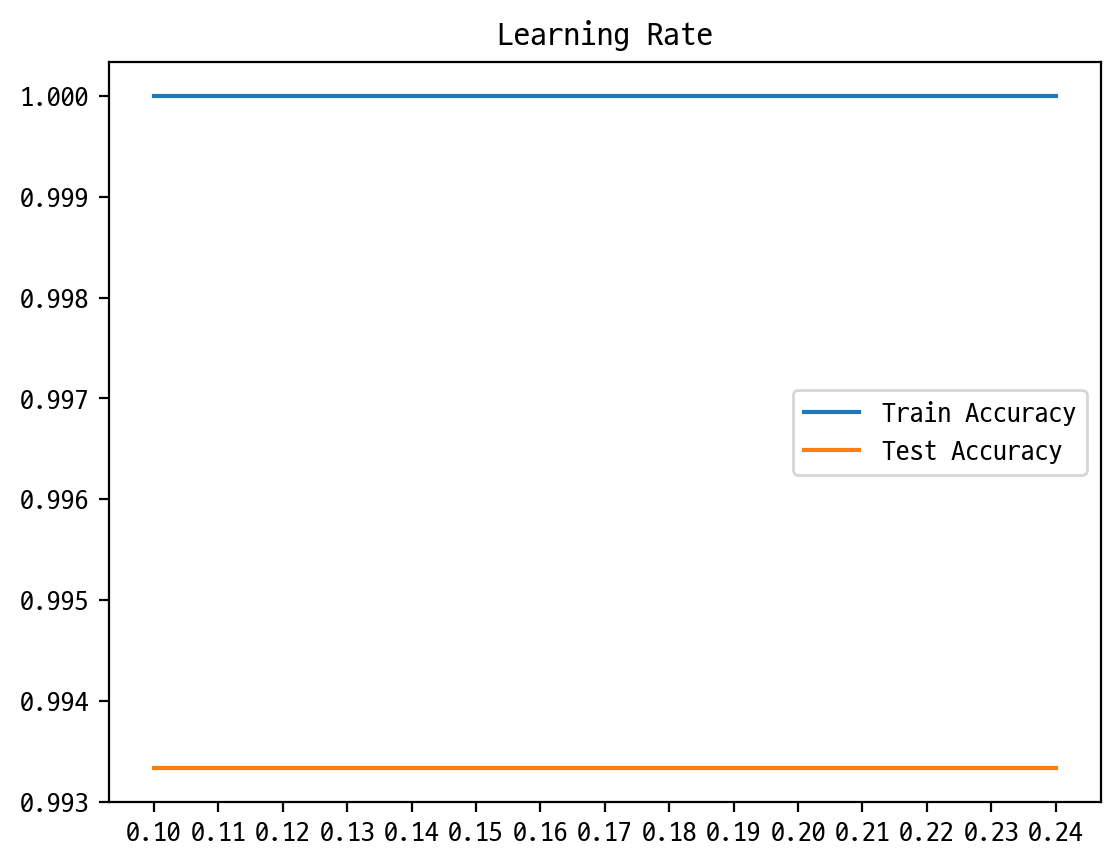

In [165]:
train_accuracy , test_accuracy = [],[]

para_lr = [lr * 0.01 for lr in range(10,25)]

for v_learning_rate in para_lr:
    lgbm = LGBMClassifier(learning_rate = v_learning_rate,n_estimators = 50 , random_state= 42)
    lgbm.fit(x_train, y_train)
    train_accuracy.append(lgbm.score(x_train, y_train))
    test_accuracy.append(lgbm.score(x_test, y_test))

df_accuracy_lr = pd.DataFrame()
df_accuracy_lr['LearningRate'] = para_lr
df_accuracy_lr['TrainAccuracy'] = train_accuracy
df_accuracy_lr['TestAccuracy'] = test_accuracy

display(df_accuracy_lr)

plt.plot(para_lr, train_accuracy, linestyle = '-', label = 'Train Accuracy')
plt.plot(para_lr, test_accuracy, linestyle = '-', label = 'Test Accuracy')
plt.xticks(para_lr)
plt.legend()
plt.title('Learning Rate')


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 217, number of negative: 483
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000688 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.310000 -> initscore=-0.800119
[LightGBM] [Info] Start training from score -0.800119
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

,MaxDepth,TrainAccuracy,TestAccuracy
0,1,1.0,0.993333
1,2,1.0,0.993333
2,3,1.0,0.993333
3,4,1.0,0.993333
4,5,1.0,0.993333
5,6,1.0,0.993333
6,7,1.0,0.993333
7,8,1.0,0.993333
8,9,1.0,0.993333
9,10,1.0,0.993333


Text(0.5, 1.0, 'max_depth')

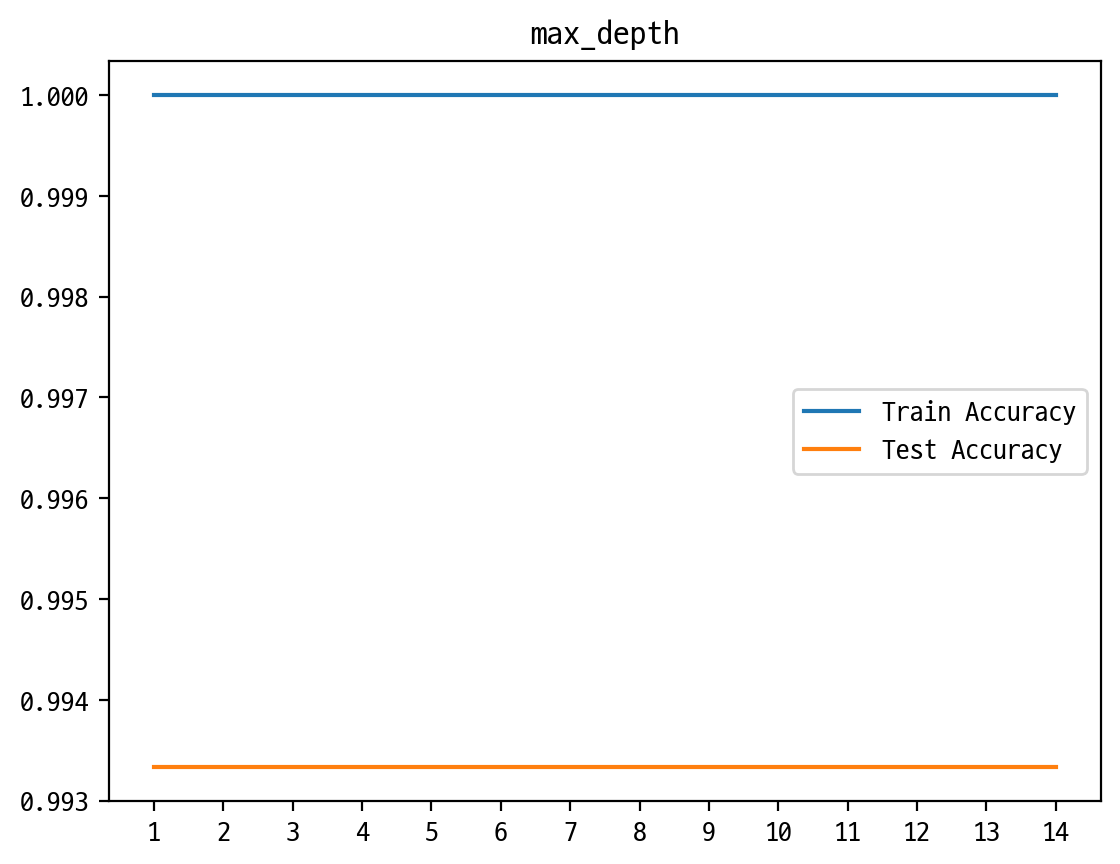

In [166]:
train_accuracy , test_accuracy = [],[]

para_depth = [depth for depth in range(1,15)]

for v_mat_depth in para_depth:
    lgbm = LGBMClassifier(max_depth = v_max_depth , n_estimators = 50 , random_state= 42)
    lgbm.fit(x_train, y_train)
    train_accuracy.append(lgbm.score(x_train, y_train))
    test_accuracy.append(lgbm.score(x_test, y_test))

df_accuracy_depth = pd.DataFrame()
df_accuracy_depth['MaxDepth'] = para_depth
df_accuracy_depth['TrainAccuracy'] = train_accuracy
df_accuracy_depth['TestAccuracy'] = test_accuracy

display(df_accuracy_depth)

plt.plot(para_depth, train_accuracy, linestyle = '-', label = 'Train Accuracy')
plt.plot(para_depth, test_accuracy, linestyle = '-', label = 'Test Accuracy')
plt.xticks(para_depth)
plt.legend()
plt.title('max_depth')


- 선택하지 않도록 하겠다.

In [162]:
lgbm_final = LGBMClassifier(n_estimators = 50 , random_state= 42)
lgbm_final.fit(x_train, y_train)

y_pred = lgbm_final.predict(x_test)

scores['LGBMClassifier'] = [lgbm_final.score(x_train , y_train),lgbm_final.score(x_test , y_test)]
params['LGBMClassifier'] = lgbm_final.get_params().values()
print('Test Confusion matrix :\n ', confusion_matrix(y_test, y_pred))
cls_report_final = classification_report(y_test, y_pred, digits = 3)
cls_report_final_lgbm = cls_reports(cls_report_final, 'lgbm')
cls_report_final_lgbm

[LightGBM] [Info] Number of positive: 217, number of negative: 483
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000670 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.310000 -> initscore=-0.800119
[LightGBM] [Info] Start training from score -0.800119
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

,precision_lgbm,recall_lgbm,f1-score_lgbm,support_lgbm
0,0.995,0.995,0.995,207
1,0.989,0.989,0.989,93
accuracy,-,-,0.993,300
macro avg,0.992,0.992,0.992,300
weighted avg,0.993,0.993,0.993,300


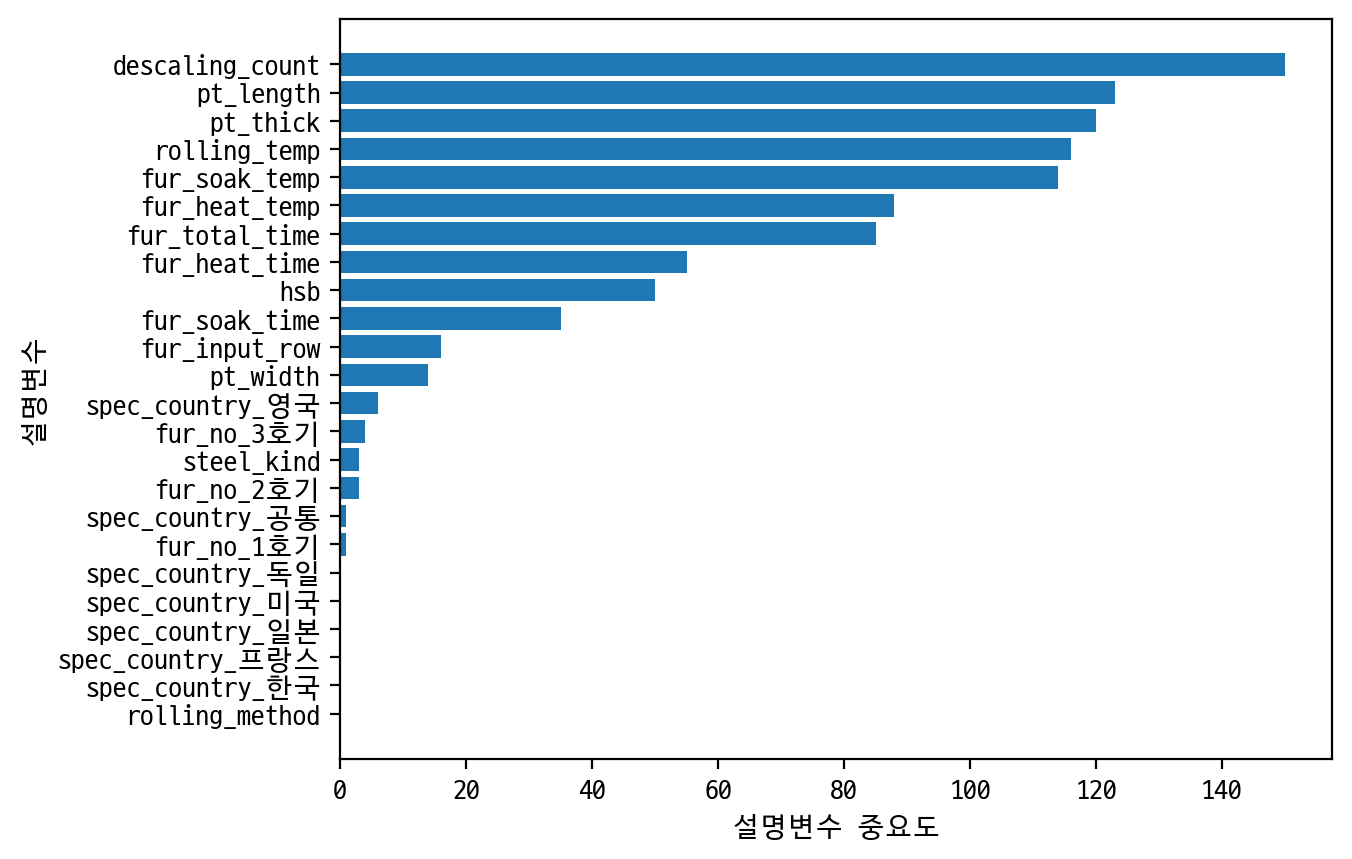

In [163]:
df_importance = pd.DataFrame()
df_importance['Feature'] = x_test.columns
df_importance['Importance'] = lgbm_final.feature_importances_

df_importance.sort_values("Importance", ascending = True, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y= coordinates, width = df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('설명변수 중요도')
plt.ylabel('설명변수')
plt.show()

앞선 EDA 과정에서 이야기 했었던 가정들을 다시한번 살펴보겠다.
1. Spec_country 변수들을 통하여 일본의 경우 데이터가 많음에도 불구하고 불량률이 높게 나와 특이한 상황이 발생했을 것으로 추측한다.
2. HSB 변수는 적용 유무와 양품 불량의 비율이 강한 상관관계가 있는 것으로 보이므로 중요한 변수일 것이다.
3. Rolling Method가 불량률이 높게 나온 것은 단순히 count가 많이 나와 불량이 일어날 확률이 높아졌을 것 뿐이다.
4. pt_thick, pt_width, pt_length 변수들의 경우 소비자들에게 제공받는 규격들이지만 특정 구간의 규격들에서 불량률이 높아지는 특징을 가지므로, scale 불량과 어떠한 연관이 있을 것이다. 
5. desaling의 경우 횟수가 커질수록 양품일 확률이 높다고 할 수있을 것이다.
6. rolling temp 는 1000도 이상의 경우와 온도가 높아질수록 불량일 확률이 높아지므로 이는 scale 불량에 영향을 줄것이다.
